In [376]:
! pip3 install wordcloud
!pip3 install folium
!pip3 install wget

In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Intro

You are given the famous Airbnb Seattle dataset, this dataset contains two files:
1. calendar.csv
2. listings.csv
For your convenience, the data is loaded onto this notebook.

The questions are implemented within the notebook.
It is highly recommended to document the code and write your assumptions as notes.

By the end of the allocated time, you are kindly requested to save the notebook in the format of:

You are allowed to use any library you desire, however the assignment should be written in python via jupyter notebook.


your_name_date_assignment

In any case, you would like some cllarifications, please send a mail to saar.teboul@explorium.ai
    

# Main Task:
1. The purpose of this task is to predict the price of Seattle Airbnb rentals based on the data provided and any external dataset(s with relevant information.



### Data loading

In [422]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')

# Question 1: Data cleaning
1. Given your objective, write a short code which cleans the dataset. In your code, please explain what you have cleaned and why it is necessary
2. Cleaning means you have to make sure that:
* All columns are in the correct type (take care and think if a column should be categorical or should be converted to numerical)
* Missing data - appears only where it should appear - do you think you should address it differently? What are some known methods to handle missing data?
* Categorical columns - think how you can extract valuable information from categorical columns.

# Checking Calender data

In [423]:
calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [424]:
calendar.tail()

listing_id        date available price
1393565    10208623  2016-12-29         f   NaN
1393566    10208623  2016-12-30         f   NaN
1393567    10208623  2016-12-31         f   NaN
1393568    10208623  2017-01-01         f   NaN
1393569    10208623  2017-01-02         f   NaN

A 1 year calendar 

In [425]:
calendar.shape

(1393570, 4)

In [426]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [427]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [428]:
calendar.select_dtypes(include=['object']).isnull().sum()

available         0
price        459028
dtype: int64

* Remove the $ from price 
* Replace all NaN with 0

In [429]:
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace('[$]', '', regex=True)
calendar['price'] = calendar['price'].astype(float)
calendar['price'] = calendar['price'].replace(np.NaN, 0)

In [430]:
calendar['price'].dtypes

dtype('float64')

In [431]:
calendar.select_dtypes(exclude=['object']).isnull().sum()

listing_id    0
date          0
price         0
dtype: int64

In [432]:
calendar['available'] = calendar['available'].replace('t',1)
calendar['available'] = calendar['available'].replace('f',0)

In [433]:
calendar.available.value_counts()

1    934542
0    459028
Name: available, dtype: int64

Almost 50% availability

In [434]:
calendar_1 = calendar.groupby('date')['available'].mean().reset_index()
calendar_1

date  available
0   2016-01-04   0.454426
1   2016-01-05   0.488999
2   2016-01-06   0.478261
3   2016-01-07   0.465165
4   2016-01-08   0.466737
..         ...        ...
360 2016-12-29   0.742535
361 2016-12-30   0.743845
362 2016-12-31   0.748821
363 2017-01-01   0.765322
364 2017-01-02   0.727082

[365 rows x 2 columns]

* Calculate Availability Vs Date

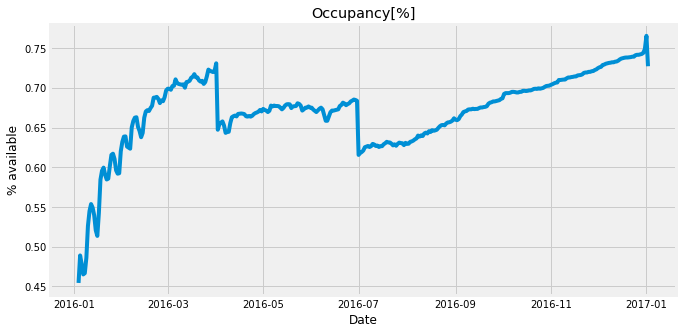

In [435]:
plt.figure(figsize=(10, 5))
plt.plot(calendar_1['date'], calendar_1['available'])
plt.title('Occupancy[%]')
plt.xlabel('Date')
plt.ylabel('% available')
plt.show()

* From the above we can detect seasonality in booking \
Also we can accept price fluctuation during the hot seasons 4,7,12

* Calculate price per Month

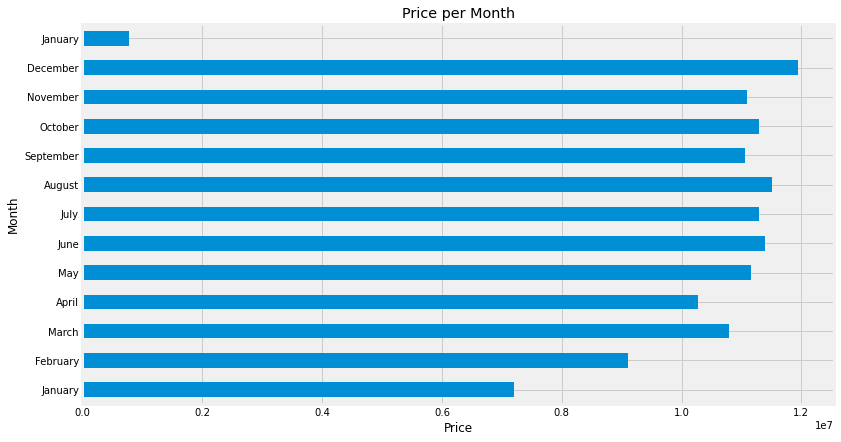

In [436]:
calendar_month = calendar.groupby(pd.Grouper(key='date', freq='1M')).sum() # groupby each 1 month
calendar_month.index = calendar_month.index.strftime('%B')
calendar_month.price.plot(kind='barh',figsize = (12,7))
plt.title('Price per Month')
plt.xlabel('Price')
plt.ylabel('Month')
plt.show()

* From the price distribution by month, we can see that the hottest season is december \
where prices are at the max, but over all the differences are not significant to create a new feature 'by_month'

In [437]:
calendar_month.head()

listing_id  available       price
date                                         
January   593329111088      59239   7201591.0
February  614519436484      73321   9113355.0
March     656900087276      83938  10798161.0
April     635709761880      76037  10272371.0
May       656900087276      79971  11159008.0

# Checking listings data

In [438]:
listings.shape

(3818, 92)

In [439]:
listings.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   
3                                                NaN  ...                 NaN   
4  We are in the beautiful neighborhood of Queen ...  ...                 9.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   
3                f     NaN         WASHINGTON                f   
4                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   
3            flexible                              f   
4              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

In [440]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [441]:
# List of all non object data - numbers
listings.dtypes[listings.dtypes!='object']

id                                  int64
scrape_id                           int64
host_id                             int64
host_listings_count               float64
host_total_listings_count         float64
latitude                          float64
longitude                         float64
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
beds                              float64
square_feet                       float64
guests_included                     int64
minimum_nights                      int64
maximum_nights                      int64
availability_30                     int64
availability_60                     int64
availability_90                     int64
availability_365                    int64
number_of_reviews                   int64
review_scores_rating              float64
review_scores_accuracy            float64
review_scores_cleanliness         float64
review_scores_checkin             

* split the columns into small segments for better analyzation 

In [442]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [443]:
listings.dtypes[listings.dtypes=='object']

listing_url                         object
last_scraped                        object
name                                object
summary                             object
space                               object
                                     ...  
jurisdiction_names                  object
instant_bookable                    object
cancellation_policy                 object
require_guest_profile_picture       object
require_guest_phone_verification    object
Length: 62, dtype: object

* First we will fix the currency, drop the ['$',','] and cast it to float.  

In [444]:
cols = ['price','security_deposit','extra_people','weekly_price','monthly_price','cleaning_fee']
for col in cols:     
    listings[col] = listings[col].str.replace(',', '')
    listings[col] = listings[col].str.replace('[$]', '', regex=True)
    listings[col] = listings[col].astype(float)
    listings[col] = listings[col].replace(listings[col].mean())

# We will need to dissect the data into small parts in order to investigate it's  values
First part

In [445]:
listings_1 = listings[['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
                       'space', 'description', 'experiences_offered', 'neighborhood_overview',
                       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
                       'host_location']].copy()
listings_1.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ...  \
0                                                NaN  ...   
1  Queen Anne is a wonderful, truly functional vi...  ...   
2  Upper Queen Anne is a charming neighborhood fu...  ...   
3                                                NaN  ...   
4  We are in the beautiful neighborhood of Queen ...  ...   

                                             transit  \
0                                                NaN   
1  Convenient bus stops are just down the block, ...   
2  A bus stop is just 2 blocks away.   Easy bus a...   
3                                                NaN   
4  The nearest public transit bus (D Line) is 2 b...   

                                       thumbnail_url  \
0                                                NaN   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                          medium_url  \
0                                                NaN   
1  https://a0.muscache.com/im/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         picture_url  \
0  https://a1.muscache.com/ac/pictures/67560560/c...   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2  https://a2.muscache.com/ac/pictures/b4324e0f-a...   
3  https://a0.muscache.com/ac/pictures/94146944/6...   
4  https://a1.muscache.com/ac/pictures/6120468/b0...   

                                      xl_picture_url   host_id  \
0                                                NaN    956883   
1  https://a0.muscache.com/ac/pictures/14409893/f...   5177328   
2                                                NaN  16708587   
3                                                NaN   9851441   
4                                                NaN   1452570   

                         

In [446]:
listings_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     3818 non-null   int64 
 1   listing_url            3818 non-null   object
 2   scrape_id              3818 non-null   int64 
 3   last_scraped           3818 non-null   object
 4   name                   3818 non-null   object
 5   summary                3641 non-null   object
 6   space                  3249 non-null   object
 7   description            3818 non-null   object
 8   experiences_offered    3818 non-null   object
 9   neighborhood_overview  2786 non-null   object
 10  notes                  2212 non-null   object
 11  transit                2884 non-null   object
 12  thumbnail_url          3498 non-null   object
 13  medium_url             3498 non-null   object
 14  picture_url            3818 non-null   object
 15  xl_picture_url       

In [447]:
listings_1.isnull().sum()

id                          0
listing_url                 0
scrape_id                   0
last_scraped                0
name                        0
summary                   177
space                     569
description                 0
experiences_offered         0
neighborhood_overview    1032
notes                    1606
transit                   934
thumbnail_url             320
medium_url                320
picture_url                 0
xl_picture_url            320
host_id                     0
host_url                    0
host_name                   2
host_since                  2
host_location               8
dtype: int64

In [448]:
from collections import Counter

names=[]
#Getting name string from 'name' column and appending it to the empty list
for name in listings_1.name:
    names.append(name)
#Setting a function to split name strings into seperate words
def split_name(name):
    s = str(name).split()
    return s
#Create empty list where we are going to count the words
names_count = []
#Getting name string to appending it to the names_count list
for n in names:
    for word in split_name(n):
        word = word.lower()
        names_count.append(word)

top_25 = Counter(names_count).most_common()
top_25 = top_25[:25]

[Text(0, 0, 'in'),
 Text(1, 0, 'seattle'),
 Text(2, 0, 'hill'),
 Text(3, 0, 'room'),
 Text(4, 0, 'home'),
 Text(5, 0, 'private'),
 Text(6, 0, 'capitol'),
 Text(7, 0, 'apartment'),
 Text(8, 0, 'modern'),
 Text(9, 0, 'cozy'),
 Text(10, 0, 'studio'),
 Text(11, 0, 'the'),
 Text(12, 0, 'downtown'),
 Text(13, 0, 'view'),
 Text(14, 0, '-'),
 Text(15, 0, 'bedroom'),
 Text(16, 0, 'near'),
 Text(17, 0, 'house'),
 Text(18, 0, '&'),
 Text(19, 0, 'with'),
 Text(20, 0, 'of'),
 Text(21, 0, '2'),
 Text(22, 0, '1'),
 Text(23, 0, 'to'),
 Text(24, 0, 'lake')]

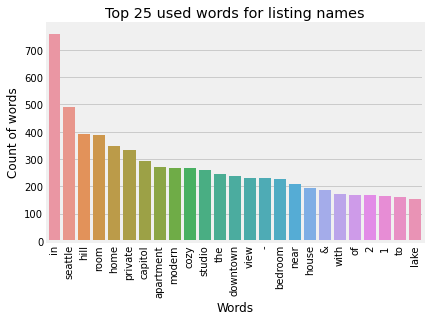

In [449]:
word_count_data = pd.DataFrame(top_25)
word_count_data.rename(columns={0:'Words',1:'Counts'},inplace=True)
viz_count = sns.barplot(x='Words',y='Counts', data = word_count_data)
viz_count.set_title('Top 25 used words for listing names')
viz_count.set_ylabel('Count of words')
viz_count.set_xlabel('Words')
viz_count.set_xticklabels(viz_count.get_xticklabels(),rotation = 90)

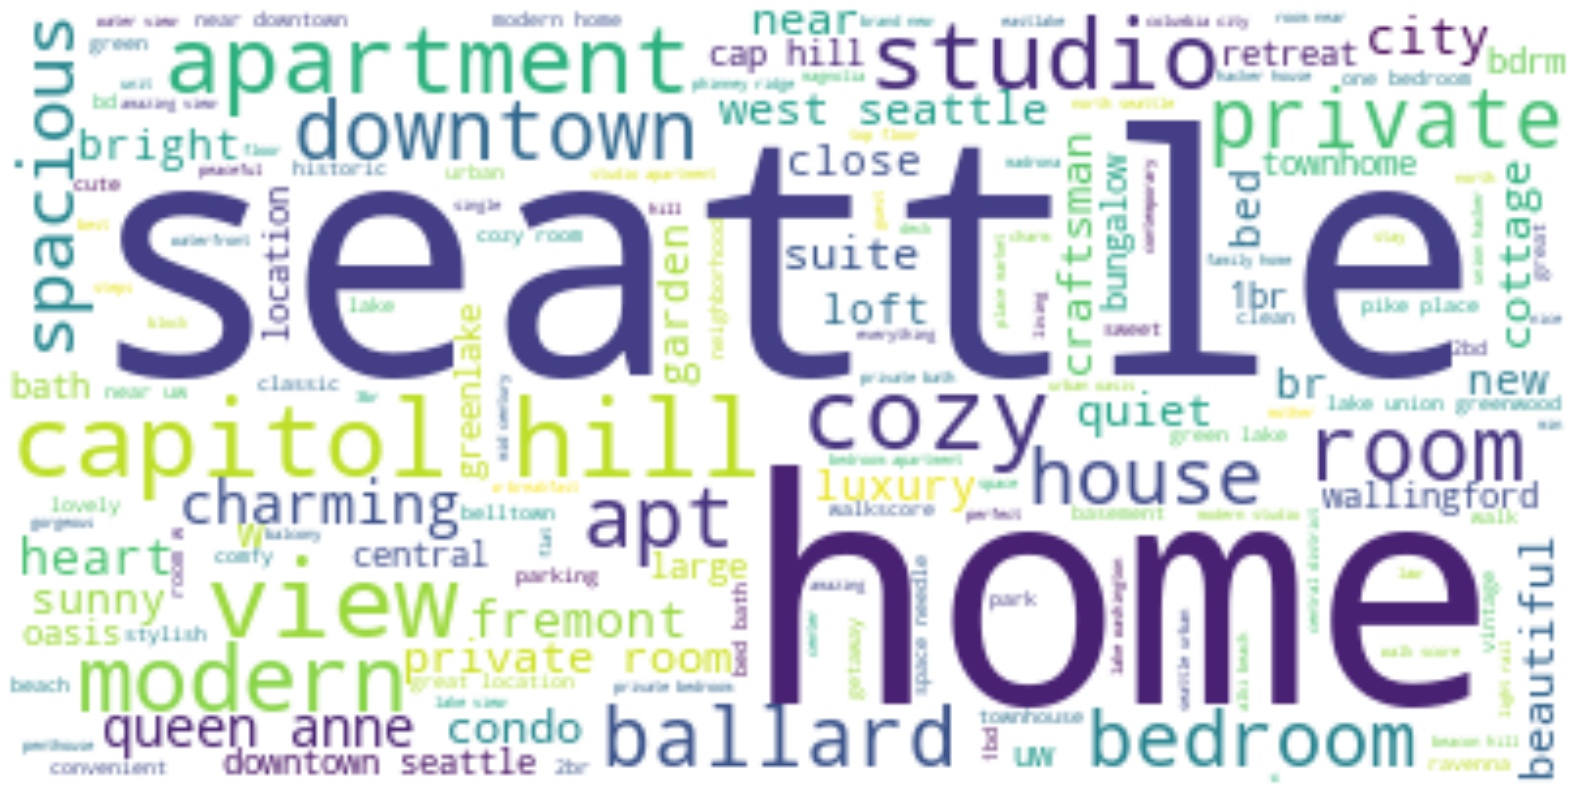

In [450]:
from wordcloud import WordCloud, ImageColorGenerator

text = ' '.join(str(n).lower() for n in listings_1.name)
#Generate wordcloud image
wordcloud = WordCloud(max_words=200, background_color = 'white').generate(text)
plt.figure(figsize=(25,20))
#Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

From the above picture we can get agood clue on which words are more frequent and also \
what are the importent features that we can look for in neighbourhood (capital hill) \
and also others parameters like property type & room type \
This is only informetive, but we can create a new bool column labeled 'Top_10_word'



In [451]:
# calculate time from first entry to last date scraped to create Seniority_days (how long the property exist)
# to deal with 2 missing in host_since we will update the column with last_scraped
# This is to avoid 'nan' and delete the row and loose information
# The nan could not be filled with df.replace() beacuse it was 'NaT'

listings_1['last_scraped'] = pd.to_datetime(listings_1['last_scraped'])

# apperentlly there is a "NaT" that need to be found manually.
listings_1['host_since'][1419] = listings_1['last_scraped'][1419]
listings_1['host_since'][1297] = listings_1['last_scraped'][1297]
listings_1['host_since'] = pd.to_datetime(listings_1['host_since'])
listings_1['Seniority_days'] = listings_1['last_scraped'] - listings_1['host_since']
listings_1['Seniority_days'] = listings_1['Seniority_days'].astype('timedelta64[s]')/(24*60*60)


<ipython-input-451-49d3d7e5c516>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_1['host_since'][1419] = listings_1['last_scraped'][1419]
<ipython-input-451-49d3d7e5c516>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_1['host_since'][1297] = listings_1['last_scraped'][1297]


In [452]:
listings_1['host_since'].isnull().sum()

0

In [453]:
for index in range(len(listings_1['host_since'])):
    print(index, listings_1['host_since'][index])

0 2011-08-11 00:00:00
1 2013-02-21 00:00:00
2 2014-06-12 00:00:00
3 2013-11-06 00:00:00
4 2011-11-29 00:00:00
5 2010-12-25 00:00:00
6 2012-05-30 00:00:00
7 2012-10-30 00:00:00
8 2012-04-18 00:00:00
9 2013-02-21 00:00:00
10 2010-09-19 00:00:00
11 2013-01-06 00:00:00
12 2014-08-13 00:00:00
13 2015-01-10 00:00:00
14 2014-10-10 00:00:00
15 2012-07-18 00:00:00
16 2013-10-16 00:00:00
17 2014-12-31 00:00:00
18 2013-04-30 00:00:00
19 2015-05-05 00:00:00
20 2014-04-09 00:00:00
21 2014-09-16 00:00:00
22 2015-10-16 00:00:00
23 2015-12-20 00:00:00
24 2015-05-11 00:00:00
25 2014-06-12 00:00:00
26 2010-01-06 00:00:00
27 2012-10-30 00:00:00
28 2012-10-07 00:00:00
29 2013-05-01 00:00:00
30 2013-02-21 00:00:00
31 2013-03-04 00:00:00
32 2015-04-11 00:00:00
33 2015-01-10 00:00:00
34 2013-09-18 00:00:00
35 2015-08-02 00:00:00
36 2013-05-23 00:00:00
37 2014-09-08 00:00:00
38 2015-08-02 00:00:00
39 2012-04-02 00:00:00
40 2014-09-28 00:00:00
41 2013-08-18 00:00:00
42 2012-05-07 00:00:00
43 2014-07-03 00:00:0

1429 2011-03-20 00:00:00
1430 2011-11-09 00:00:00
1431 2012-05-07 00:00:00
1432 2015-04-02 00:00:00
1433 2015-04-21 00:00:00
1434 2015-11-06 00:00:00
1435 2014-03-01 00:00:00
1436 2012-08-02 00:00:00
1437 2011-05-13 00:00:00
1438 2015-08-11 00:00:00
1439 2014-07-25 00:00:00
1440 2014-11-06 00:00:00
1441 2011-08-27 00:00:00
1442 2013-12-17 00:00:00
1443 2013-02-06 00:00:00
1444 2015-01-11 00:00:00
1445 2015-01-11 00:00:00
1446 2015-10-31 00:00:00
1447 2011-08-27 00:00:00
1448 2015-11-13 00:00:00
1449 2009-12-28 00:00:00
1450 2009-12-28 00:00:00
1451 2015-06-14 00:00:00
1452 2014-07-10 00:00:00
1453 2010-04-12 00:00:00
1454 2013-02-06 00:00:00
1455 2013-12-17 00:00:00
1456 2013-09-10 00:00:00
1457 2012-10-23 00:00:00
1458 2015-08-11 00:00:00
1459 2013-03-17 00:00:00
1460 2013-08-30 00:00:00
1461 2012-12-15 00:00:00
1462 2011-02-14 00:00:00
1463 2014-10-22 00:00:00
1464 2015-10-25 00:00:00
1465 2013-02-04 00:00:00
1466 2013-08-30 00:00:00
1467 2013-09-25 00:00:00
1468 2011-12-06 00:00:00


2929 2014-06-22 00:00:00
2930 2013-04-07 00:00:00
2931 2011-10-03 00:00:00
2932 2015-11-25 00:00:00
2933 2011-03-19 00:00:00
2934 2013-06-09 00:00:00
2935 2013-10-06 00:00:00
2936 2010-06-21 00:00:00
2937 2014-09-15 00:00:00
2938 2015-10-05 00:00:00
2939 2014-03-15 00:00:00
2940 2013-04-12 00:00:00
2941 2015-06-30 00:00:00
2942 2011-10-03 00:00:00
2943 2013-09-23 00:00:00
2944 2013-03-03 00:00:00
2945 2010-04-18 00:00:00
2946 2015-08-14 00:00:00
2947 2015-05-09 00:00:00
2948 2015-09-11 00:00:00
2949 2013-03-17 00:00:00
2950 2015-08-25 00:00:00
2951 2015-08-13 00:00:00
2952 2013-05-08 00:00:00
2953 2011-09-07 00:00:00
2954 2015-07-09 00:00:00
2955 2016-01-03 00:00:00
2956 2014-01-17 00:00:00
2957 2013-01-03 00:00:00
2958 2014-11-28 00:00:00
2959 2014-03-19 00:00:00
2960 2014-04-16 00:00:00
2961 2013-07-23 00:00:00
2962 2014-08-18 00:00:00
2963 2012-04-06 00:00:00
2964 2015-07-10 00:00:00
2965 2014-10-12 00:00:00
2966 2015-06-21 00:00:00
2967 2014-03-26 00:00:00
2968 2013-04-01 00:00:00


In [454]:
listings_1.experiences_offered.value_counts()

none    3818
Name: experiences_offered, dtype: int64

Drop experiences_offered, have only 1 value

In [455]:
listings_1.host_location.value_counts()

Seattle, Washington, United States         3259
US                                          246
Spokane, Washington, United States           41
Kent, Washington, United States              34
Los Angeles, California, United States       13
                                           ... 
Mount Vernon, Washington, United States       1
Dallas, Texas, United States                  1
Alamosa, Colorado, United States              1
Gig Harbor, Washington, United States         1
Camano Island                                 1
Name: host_location, Length: 120, dtype: int64

We can split the data into two bins
1. Seattle
2. Outside Seattle
Or we can drop it (depend on it importance in the model section)

In [456]:
listings_1['Seattle_location'] = ((listings_1.host_location == 'Seattle, Washington, United States')).astype('bool')
listings_1['Others_location'] = ((listings_1.host_location != 'Seattle, Washington, United States')).astype('bool')

cols = ['Seattle_location', 'Others_location']
for col in cols:
    listings_1[col] = listings_1[col].replace(False, 0)
    listings_1[col] = listings_1[col].replace(True, 1)

Drop all unnecessary columns
* Remove all cells that contains url,
we will not run on them or make further analysis on pictures. \
(beyond the scope of this exercise)
* Remove any index/serial/name category that doesnt add value to the result

In [457]:
listings_1.drop(['experiences_offered','host_id','host_name','listing_url','host_location','last_scraped','id','scrape_id',
                 'host_since','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','summary','space',
                 'description','transit','notes','neighborhood_overview','name'], axis=1,inplace=True)

In [458]:
listings_1.head()

Seniority_days  Seattle_location  Others_location
0          1607.0                 1                0
1          1047.0                 1                0
2           571.0                 1                0
3           789.0                 1                0
4          1497.0                 1                0

In [459]:
listings_1.isnull().sum()

Seniority_days      0
Seattle_location    0
Others_location     0
dtype: int64

In [460]:
listings_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Seniority_days    3818 non-null   float64
 1   Seattle_location  3818 non-null   int64  
 2   Others_location   3818 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 89.6 KB


# Second part

In [461]:
listings_2 = listings[['host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified']].copy()
listings_2.head()

host_about  host_response_time  \
0  I am an artist, interior designer, and run a s...  within a few hours   
1  Living east coast/left coast/overseas.  Time i...      within an hour   
2  i love living in Seattle.  i grew up in the mi...  within a few hours   
3                                                NaN                 NaN   
4  Hi, I live in Seattle, Washington but I'm orig...      within an hour   

  host_response_rate host_acceptance_rate host_is_superhost  \
0                96%                 100%                 f   
1                98%                 100%                 t   
2                67%                 100%                 f   
3                NaN                  NaN                 f   
4               100%                  NaN                 f   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/ac/users/956883/profil...   
1  https://a0.muscache.com/ac/users/5177328/profi...   
2  https://a1.muscache.com/ac/users/16708587/prof...   
3  https://a2.muscache.com/ac/users/9851441/profi...   
4  https://a0.muscache.com/ac/users/1452570/profi...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/ac/users/956883/profil...         Queen Anne   
1  https://a0.muscache.com/ac/users/5177328/profi...         Queen Anne   
2  https://a1.muscache.com/ac/users/16708587/prof...         Queen Anne   
3  https://a2.muscache.com/ac/users/9851441/profi...         Queen Anne   
4  https://a0.muscache.com/ac/users/1452570/profi...         Queen Anne   

   host_listings_count  host_total_listings_count  \
0                  3.0                        3.0   
1                  6.0                        6.0   
2                  2.0                        2.0   
3                  1.0                        1.0   
4                  2.0                        2.0   

                                  host_verifications host_has_profile_pic  \
0               ['email', 'phone', 'reviews', 'kba']                    t   
1  ['email', 'phone', 'facebook', 'linkedin', 're...                    t   
2   ['email', 'phone', 'google', 'reviews', 'jumio']                    t   
3  ['email', 'phone', 'facebook', 'reviews', 'jum...                    t   
4   ['email', 'phone', 'facebook', 'reviews', 'kba']                    t   

  host_identity_verified  
0                      t  
1                      t  
2                      t  
3                      t  
4                      t

In [462]:
listings_2.isnull().sum()

host_about                   859
host_response_time           523
host_response_rate           523
host_acceptance_rate         773
host_is_superhost              2
host_thumbnail_url             2
host_picture_url               2
host_neighbourhood           300
host_listings_count            2
host_total_listings_count      2
host_verifications             0
host_has_profile_pic           2
host_identity_verified         2
dtype: int64

In [463]:
listings_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_about                 2959 non-null   object 
 1   host_response_time         3295 non-null   object 
 2   host_response_rate         3295 non-null   object 
 3   host_acceptance_rate       3045 non-null   object 
 4   host_is_superhost          3816 non-null   object 
 5   host_thumbnail_url         3816 non-null   object 
 6   host_picture_url           3816 non-null   object 
 7   host_neighbourhood         3518 non-null   object 
 8   host_listings_count        3816 non-null   float64
 9   host_total_listings_count  3816 non-null   float64
 10  host_verifications         3818 non-null   object 
 11  host_has_profile_pic       3816 non-null   object 
 12  host_identity_verified     3816 non-null   object 
dtypes: float64(2), object(11)
memory usage: 387.9+ K

In [464]:
listings_2.host_is_superhost.value_counts()

f    3038
t     778
Name: host_is_superhost, dtype: int64

In [465]:
listings_2.host_is_superhost = listings_2.host_is_superhost.replace(np.nan, 'f')

In [466]:
listings_2.host_listings_count.describe()

count    3816.000000
mean        7.157757
std        28.628149
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       502.000000
Name: host_listings_count, dtype: float64

<AxesSubplot:>

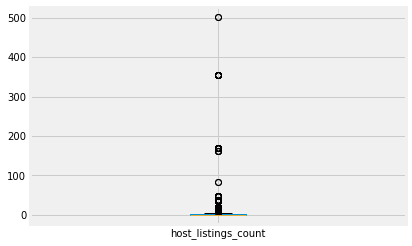

In [467]:
listings_2.host_listings_count.plot(kind='box')

In [468]:
listings_2.host_listings_count.describe()
# we will use 200 as upper limit

count    3816.000000
mean        7.157757
std        28.628149
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       502.000000
Name: host_listings_count, dtype: float64

In [469]:
listings_2.host_listings_count = listings_2.host_listings_count.replace(np.nan, listings_2.host_listings_count.mean())

In [470]:
listings_2.host_identity_verified.describe()

count     3816
unique       2
top          t
freq      2997
Name: host_identity_verified, dtype: object

In [471]:
listings_2.host_identity_verified.value_counts()

t    2997
f     819
Name: host_identity_verified, dtype: int64

* After failing to find the missing values go to manuall

In [472]:
for index in range(len(listings_2.host_identity_verified)):
    print(index, listings_2.host_identity_verified[index])

0 t
1 t
2 t
3 t
4 t
5 t
6 t
7 t
8 t
9 t
10 t
11 t
12 t
13 t
14 t
15 f
16 t
17 t
18 t
19 t
20 t
21 f
22 f
23 f
24 f
25 t
26 t
27 t
28 t
29 t
30 t
31 t
32 t
33 t
34 f
35 t
36 t
37 f
38 t
39 t
40 t
41 t
42 t
43 t
44 t
45 t
46 t
47 t
48 t
49 t
50 t
51 t
52 t
53 f
54 t
55 t
56 t
57 t
58 f
59 t
60 t
61 t
62 f
63 t
64 f
65 t
66 t
67 t
68 t
69 f
70 f
71 t
72 t
73 t
74 t
75 t
76 t
77 t
78 t
79 t
80 t
81 t
82 t
83 t
84 t
85 t
86 f
87 t
88 t
89 t
90 t
91 t
92 t
93 f
94 f
95 t
96 t
97 t
98 f
99 t
100 t
101 t
102 t
103 t
104 t
105 t
106 t
107 t
108 t
109 t
110 t
111 t
112 t
113 t
114 f
115 t
116 t
117 t
118 f
119 t
120 t
121 t
122 t
123 t
124 t
125 t
126 t
127 t
128 f
129 f
130 f
131 t
132 f
133 t
134 t
135 f
136 t
137 f
138 t
139 t
140 t
141 t
142 t
143 t
144 t
145 t
146 f
147 t
148 t
149 t
150 f
151 t
152 f
153 t
154 t
155 t
156 t
157 f
158 t
159 t
160 f
161 f
162 t
163 t
164 f
165 t
166 t
167 t
168 t
169 t
170 f
171 t
172 t
173 t
174 t
175 t
176 t
177 t
178 t
179 t
180 t
181 t
182 t
183 t
184 t


1590 t
1591 t
1592 t
1593 t
1594 t
1595 t
1596 t
1597 t
1598 t
1599 t
1600 t
1601 t
1602 t
1603 t
1604 t
1605 t
1606 t
1607 t
1608 t
1609 f
1610 t
1611 f
1612 t
1613 t
1614 t
1615 t
1616 t
1617 f
1618 t
1619 t
1620 t
1621 t
1622 f
1623 t
1624 t
1625 f
1626 t
1627 t
1628 t
1629 t
1630 t
1631 t
1632 f
1633 t
1634 t
1635 t
1636 t
1637 t
1638 t
1639 f
1640 t
1641 t
1642 t
1643 t
1644 f
1645 t
1646 f
1647 t
1648 t
1649 f
1650 t
1651 t
1652 t
1653 t
1654 t
1655 t
1656 f
1657 t
1658 t
1659 t
1660 t
1661 t
1662 t
1663 t
1664 t
1665 f
1666 f
1667 t
1668 t
1669 t
1670 f
1671 t
1672 t
1673 t
1674 t
1675 f
1676 f
1677 t
1678 t
1679 f
1680 f
1681 t
1682 t
1683 t
1684 t
1685 f
1686 t
1687 t
1688 t
1689 f
1690 t
1691 f
1692 t
1693 t
1694 t
1695 t
1696 t
1697 t
1698 t
1699 t
1700 t
1701 t
1702 t
1703 t
1704 f
1705 f
1706 t
1707 t
1708 t
1709 t
1710 t
1711 t
1712 f
1713 t
1714 t
1715 t
1716 t
1717 t
1718 t
1719 t
1720 t
1721 f
1722 f
1723 t
1724 t
1725 f
1726 t
1727 t
1728 t
1729 f
1730 f
1731 t
1732 t

3290 t
3291 t
3292 f
3293 t
3294 t
3295 t
3296 f
3297 t
3298 t
3299 t
3300 t
3301 t
3302 t
3303 t
3304 t
3305 t
3306 t
3307 t
3308 t
3309 f
3310 t
3311 t
3312 t
3313 f
3314 t
3315 f
3316 f
3317 t
3318 f
3319 f
3320 t
3321 t
3322 t
3323 t
3324 t
3325 t
3326 t
3327 t
3328 f
3329 t
3330 f
3331 f
3332 t
3333 t
3334 t
3335 t
3336 t
3337 t
3338 t
3339 t
3340 f
3341 t
3342 t
3343 t
3344 t
3345 t
3346 t
3347 t
3348 t
3349 t
3350 t
3351 t
3352 f
3353 t
3354 t
3355 t
3356 t
3357 t
3358 t
3359 t
3360 t
3361 t
3362 t
3363 f
3364 t
3365 f
3366 f
3367 t
3368 t
3369 t
3370 t
3371 t
3372 t
3373 t
3374 t
3375 f
3376 t
3377 t
3378 t
3379 t
3380 t
3381 t
3382 t
3383 t
3384 t
3385 t
3386 t
3387 t
3388 t
3389 f
3390 t
3391 t
3392 t
3393 t
3394 t
3395 t
3396 f
3397 t
3398 t
3399 t
3400 f
3401 t
3402 t
3403 f
3404 f
3405 t
3406 t
3407 f
3408 t
3409 t
3410 t
3411 t
3412 t
3413 t
3414 t
3415 t
3416 f
3417 t
3418 f
3419 t
3420 t
3421 f
3422 t
3423 t
3424 t
3425 t
3426 t
3427 f
3428 t
3429 t
3430 t
3431 f
3432 t

In [473]:
listings_2.host_identity_verified[1297]= 't'
listings_2.host_identity_verified[1419]= 't'
listings_2.host_identity_verified.isnull().sum()

<ipython-input-473-c23c07ff6ec1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_2.host_identity_verified[1297]= 't'
<ipython-input-473-c23c07ff6ec1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_2.host_identity_verified[1419]= 't'


0

In [474]:
listings_2.host_has_profile_pic.value_counts()
# Since 99.99% values are 't' we will Drop this column


t    3809
f       7
Name: host_has_profile_pic, dtype: int64

In [475]:
listings_2.host_response_time.unique()

array(['within a few hours', 'within an hour', nan, 'within a day',
       'a few days or more'], dtype=object)

In [476]:
listings_2.host_response_time.isnull().sum()
# Could be a one hot encoding , buy too many missing values exist to fill in

523

In [477]:
cols = ['host_acceptance_rate','host_response_rate']
for col in cols:
    listings_2[col] = listings_2[col].str.replace('%', '')
    listings_2[col] = listings_2[col].replace(np.nan, '0')
    listings_2[col] = listings_2[col].astype(float)
    

In [478]:
listings_2.host_acceptance_rate.describe()

count    3818.000000
mean       79.727606
std        40.208120
min         0.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

In [479]:
listings_2.host_response_rate.describe()

count    3818.000000
mean       81.888947
std        34.441009
min         0.000000
25%        88.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

* Convert all 0 to mean() \
Accourding to distribution it will not create any effect


In [480]:
cols = ['host_acceptance_rate','host_response_rate']
for col in cols:
    listings_2[col] = listings_2[col].replace(0, listings_2[col].mean())

It seems that mail, phone, facebook, reviews, linkedIn, google, kba, jumio are at the top as a preferred verification \
We can crate a new feature the top_10_varification_words, but it look there is no order or significance to \
how much there are in each. in this stage we will drop it. 


In [481]:
listings_2.host_verifications.value_counts().head(25)

['email', 'phone', 'facebook', 'reviews', 'kba']                            595
['email', 'phone', 'reviews', 'kba']                                        436
['email', 'phone', 'reviews']                                               329
['email', 'phone', 'facebook', 'reviews', 'jumio']                          322
['email', 'phone', 'reviews', 'jumio']                                      194
['email', 'phone', 'facebook', 'reviews']                                   175
['email', 'phone', 'facebook', 'linkedin', 'reviews', 'jumio']              156
['email', 'phone', 'facebook', 'linkedin', 'reviews', 'kba']                150
['email', 'phone', 'linkedin', 'reviews', 'jumio']                          145
['email', 'phone', 'linkedin', 'reviews', 'kba']                            126
['email', 'phone', 'google', 'reviews', 'jumio']                            122
['email', 'phone', 'google', 'reviews', 'kba']                              115
['email', 'phone', 'facebook', 'google',

In [482]:
listings_2.host_identity_verified.value_counts()

t    2999
f     819
Name: host_identity_verified, dtype: int64

* Converting [t,f] to [1,0]
* changing type from int64 to category

In [483]:
cols = ['host_is_superhost', 'host_identity_verified']
for col in cols:
    listings_2[col] = listings_2[col].replace('f', 0)
    listings_2[col] = listings_2[col].replace('t', 1)

In [484]:
listings_2.host_neighbourhood

0        Queen Anne
1        Queen Anne
2        Queen Anne
3        Queen Anne
4        Queen Anne
           ...     
3813          Holly
3814    Portage Bay
3815            NaN
3816            NaN
3817     Queen Anne
Name: host_neighbourhood, Length: 3818, dtype: object

- Drop all url's
- Drop all summery/about/respounce we are not running a sentiment analysis
- Drop host verification, this have little effect on price prediction. \
- Drop host_total_listings_count as it is duplicated of host_listings_count \
- Drop host_neighbourhood, it is already present in other columns
This can be tested again in model performane stage


In [485]:
listings_2.drop(['host_about','host_thumbnail_url','host_picture_url','host_verifications','host_neighbourhood',
                 'host_total_listings_count','host_response_time','host_has_profile_pic'],axis =1 ,inplace=True)


In [486]:
listings_2.head()

host_response_rate  host_acceptance_rate  host_is_superhost  \
0           96.000000            100.000000                  0   
1           98.000000            100.000000                  1   
2           67.000000            100.000000                  0   
3           81.888947             79.727606                  0   
4          100.000000             79.727606                  0   

   host_listings_count  host_identity_verified  
0                  3.0                       1  
1                  6.0                       1  
2                  2.0                       1  
3                  1.0                       1  
4                  2.0                       1

In [487]:
listings_2.isnull().sum()

host_response_rate        0
host_acceptance_rate      0
host_is_superhost         0
host_listings_count       0
host_identity_verified    0
dtype: int64

In [488]:
listings_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_rate      3818 non-null   float64
 1   host_acceptance_rate    3818 non-null   float64
 2   host_is_superhost       3818 non-null   int64  
 3   host_listings_count     3818 non-null   float64
 4   host_identity_verified  3818 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 149.3 KB


# Third part

In [489]:
listings_3 = listings[['street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates']].copy()
listings_3.head()

street neighbourhood  \
0      Gilman Dr W, Seattle, WA 98119, United States    Queen Anne   
1  7th Avenue West, Seattle, WA 98119, United States    Queen Anne   
2  West Lee Street, Seattle, WA 98119, United States    Queen Anne   
3  8th Avenue West, Seattle, WA 98119, United States    Queen Anne   
4       14th Ave W, Seattle, WA 98119, United States    Queen Anne   

  neighbourhood_cleansed neighbourhood_group_cleansed     city state zipcode  \
0        West Queen Anne                   Queen Anne  Seattle    WA   98119   
1        West Queen Anne                   Queen Anne  Seattle    WA   98119   
2        West Queen Anne                   Queen Anne  Seattle    WA   98119   
3        West Queen Anne                   Queen Anne  Seattle    WA   98119   
4        West Queen Anne                   Queen Anne  Seattle    WA   98119   

    market smart_location country_code        country   latitude   longitude  \
0  Seattle    Seattle, WA           US  United States  47.636289 -122.371025   
1  Seattle    Seattle, WA           US  United States  47.639123 -122.365666   
2  Seattle    Seattle, WA           US  United States  47.629724 -122.369483   
3  Seattle    Seattle, WA           US  United States  47.638473 -122.369279   
4  Seattle    Seattle, WA           US  United States  47.632918 -122.372471   

  is_location_exact property_type        room_type  accommodates  
0                 t     Apartment  Entire home/apt             4  
1                 t     Apartment  Entire home/apt             4  
2                 t         House  Entire home/apt            11  
3                 t     Apartment  Entire home/apt             3  
4                 t         House  Entire home/apt             6

In [490]:
import folium
import wget

In [491]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

In [492]:
listings_3['latitude'].describe()

count    3818.000000
mean       47.628961
std         0.043052
min        47.505088
25%        47.609418
50%        47.623601
75%        47.662694
max        47.733358
Name: latitude, dtype: float64

In [493]:
listings_3['longitude'].describe()

count    3818.000000
mean     -122.333103
std         0.031745
min      -122.417219
25%      -122.354320
50%      -122.328874
75%      -122.310800
max      -122.240607
Name: longitude, dtype: float64

In [494]:
#seattle_cord = [listings_3['latitude'] ,listings_3['longitude']]
cord = [47.733358,-122.240607]
site_map = folium.Map(location=cord, zoom_start=10)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

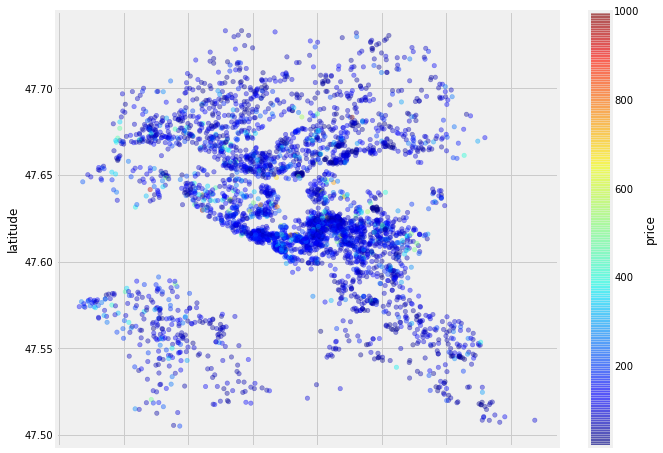

In [495]:
listings.plot(kind='scatter', x='longitude', y='latitude', c='price',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,8))

C:\Users\berge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


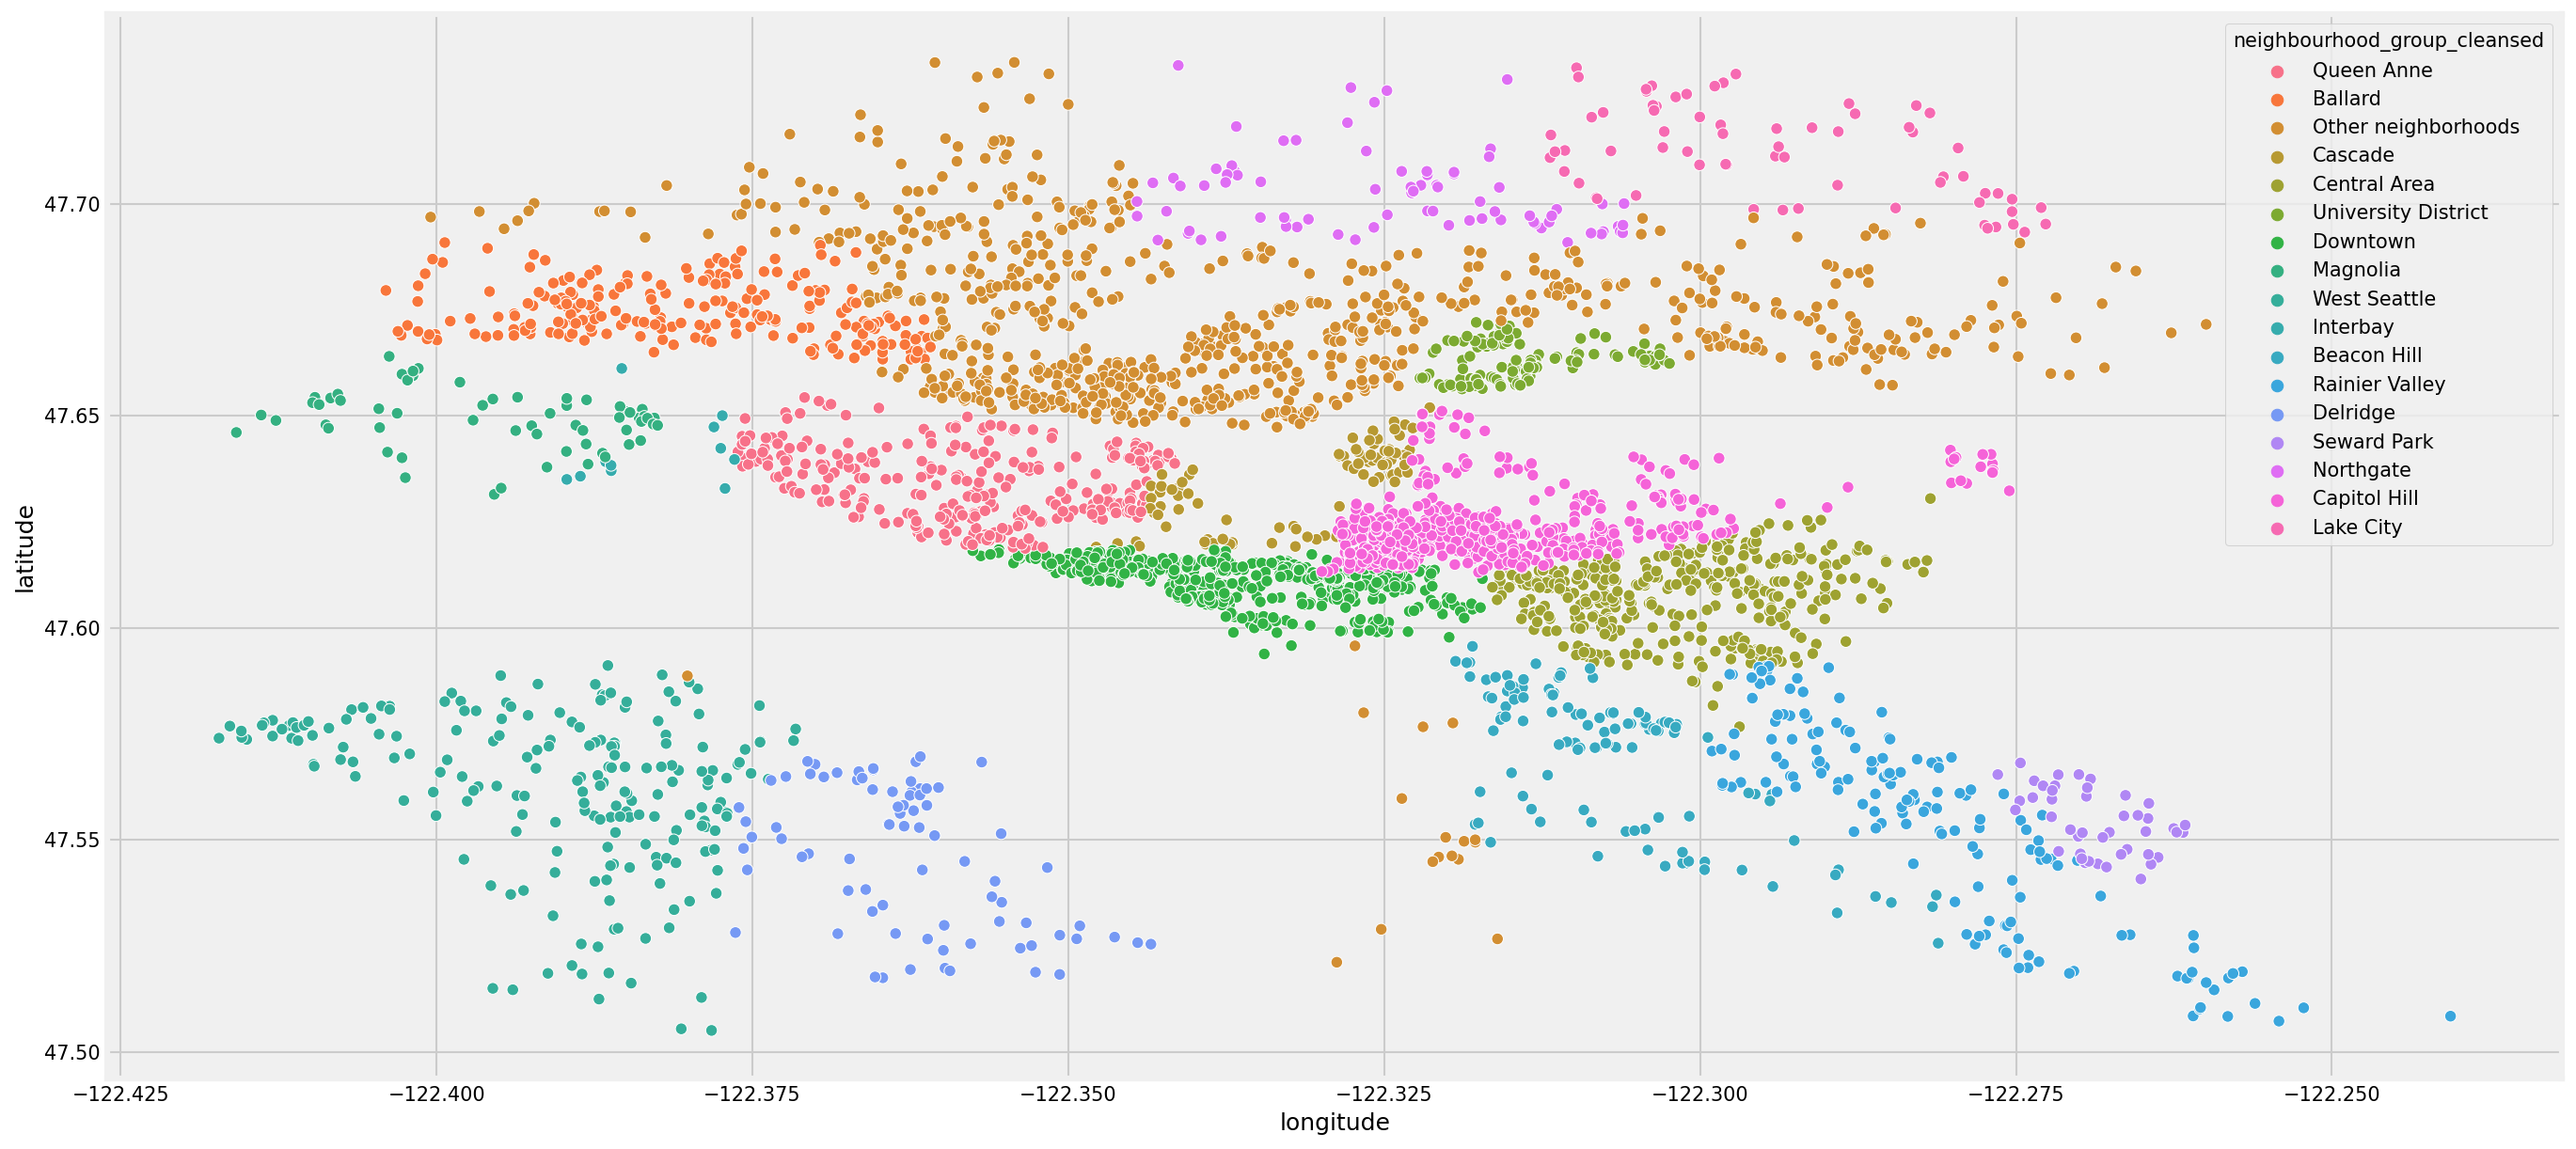

In [496]:
plt.figure(figsize=(20,10), dpi = 150)
sns.scatterplot(listings.longitude,listings.latitude,hue=listings.neighbourhood_group_cleansed)
plt.ioff()

In [497]:
def add_location_to_map(cordinate,cordinate_name):
    circle = folium.Circle(cordinate, radius=1, color='#d35400', fill=False).add_child(folium.Popup(cordinate_name))
    marker = folium.map.Marker(
        cordinate,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(1,1),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' %cordinate_name,
            ) 
        )
    site_map.add_child(circle)
    site_map.add_child(marker)
    
    return site_map

In [498]:
#plt.figure(figsize=(18,12))
#plt.style.use('fivethirtyeight')
#BBox = (103.5935, 104.0625, 1.1775, 1.5050)
#groups = listings_3.groupby('neighbourhood_group_cleansed')
#groups_count = listings_3['neighbourhood_group_cleansed'].value_counts()

#for name,group in groups :
#    plt.scatter(listings_3['longitude'],listings_3['latitude'],label=name,alpha=0.5, edgecolors='k',)

#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.legend()

In [499]:
import folium
from folium.plugins import HeatMap
# Listing Density Map
map_folium = folium.Map([47.636289038357184, -122.37102519997764],zoom_start=11.4)
HeatMap(listings_3[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(map_folium)
display(map_folium)

* As expected the more you are near the center the more properties will be 

In [500]:
# Running this flow, can make your computer go very slow.... 
# but it have a great overview on how host are scattered

#world_map = []
#for index in range(len(listings_3['latitude'])):
#    cord = [listings_3['latitude'][index],listings_3['longitude'][index]]
#    world_map = add_location_to_map(cord,'X')
#world_map

In [501]:
listings_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   street                        3818 non-null   object 
 1   neighbourhood                 3402 non-null   object 
 2   neighbourhood_cleansed        3818 non-null   object 
 3   neighbourhood_group_cleansed  3818 non-null   object 
 4   city                          3818 non-null   object 
 5   state                         3818 non-null   object 
 6   zipcode                       3811 non-null   object 
 7   market                        3818 non-null   object 
 8   smart_location                3818 non-null   object 
 9   country_code                  3818 non-null   object 
 10  country                       3818 non-null   object 
 11  latitude                      3818 non-null   float64
 12  longitude                     3818 non-null   float64
 13  is_

In [502]:
listings_3.isnull().sum()

street                            0
neighbourhood                   416
neighbourhood_cleansed            0
neighbourhood_group_cleansed      0
city                              0
state                             0
zipcode                           7
market                            0
smart_location                    0
country_code                      0
country                           0
latitude                          0
longitude                         0
is_location_exact                 0
property_type                     1
room_type                         0
accommodates                      0
dtype: int64

<AxesSubplot:>

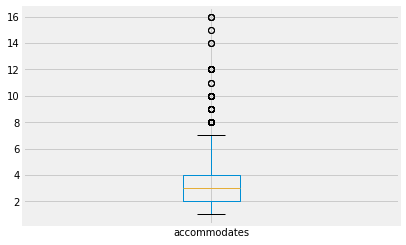

In [503]:
listings_3.accommodates.plot(kind='box')

In [504]:
listings_3.accommodates.describe()
# we will use 12 as upper limit

count    3818.000000
mean        3.349398
std         1.977599
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
Name: accommodates, dtype: float64

In [505]:
listings_3.neighbourhood_group_cleansed.unique()

array(['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City'], dtype=object)

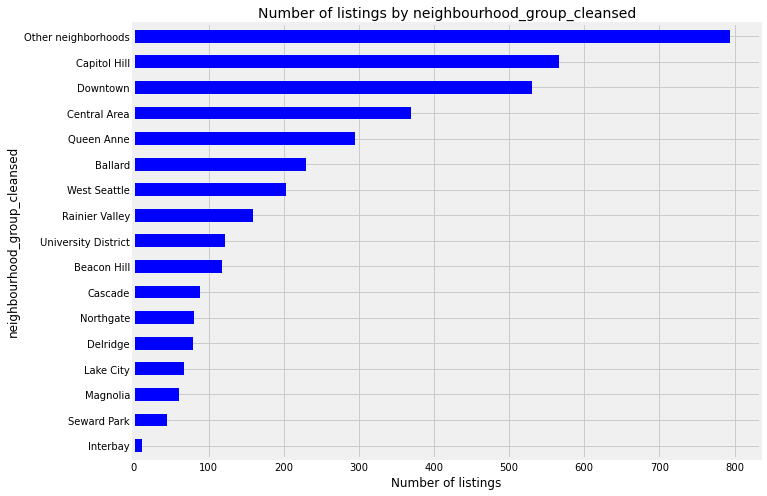

In [506]:
df_freq = listings_3['neighbourhood_group_cleansed'].value_counts().sort_values(ascending=True)
df_freq.plot.barh(figsize=(10,8), color ='b', width= 0.5)
plt.title('Number of listings by neighbourhood_group_cleansed', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('neighbourhood_group_cleansed', fontsize = 12)
plt.show()

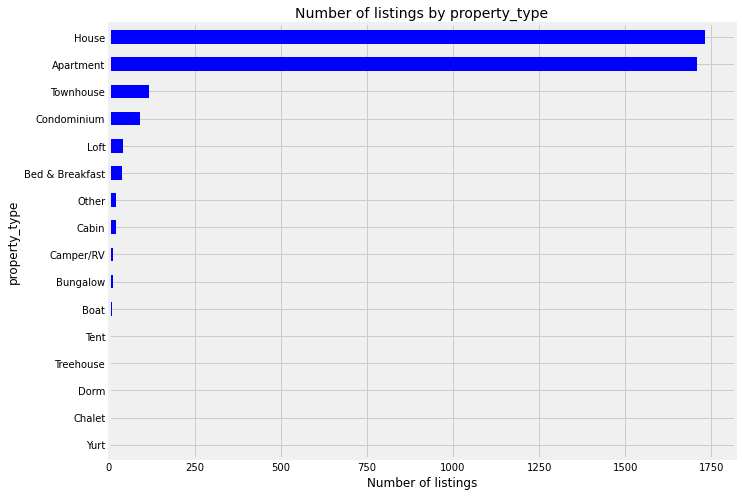

In [507]:
df_freq = listings_3.property_type.value_counts().sort_values(ascending=True).head(25)
df_freq.plot.barh(figsize=(10,8), color ='b', width= 0.5)
df_freq.plot.barh(figsize=(10,8), color ='b', width= 0.5)
plt.title('Number of listings by property_type', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('property_type', fontsize = 12)
plt.show()

We will break property_type into 3 categories: \
1.House \
2. Apartment \
3. Others

In [508]:
listings_3['property_type_house'] = ((listings_3.property_type == 'House')).astype(int)
listings_3['property_type_apartment'] = ((listings_3.property_type == 'Apartment')).astype(int)
listings_3['property_type_others'] = np.where((listings_3.property_type_house+listings_3.property_type_apartment),
                                               0, 1).astype(int)


In [509]:
listings_3.neighbourhood_cleansed.unique()

array(['West Queen Anne', 'Adams', 'West Woodland', 'East Queen Anne',
       'Wallingford', 'North Queen Anne', 'Green Lake', 'Westlake',
       'Mann', 'Madrona', 'University District', 'Harrison/Denny-Blaine',
       'Minor', 'Leschi', 'Atlantic', 'Pike-Market', 'Eastlake',
       'South Lake Union', 'Lawton Park', 'Briarcliff', 'Belltown',
       'International District', 'Central Business District',
       'First Hill', 'Yesler Terrace', 'Pioneer Square', 'Gatewood',
       'Arbor Heights', 'Alki', 'North Admiral', 'Crown Hill',
       'Fairmount Park', 'Genesee', 'Interbay', 'Industrial District',
       'Mid-Beacon Hill', 'South Beacon Hill', 'Greenwood', 'Holly Park',
       'Fauntleroy', 'North Beacon Hill', 'Mount Baker', 'Brighton',
       'South Delridge', 'View Ridge', 'Dunlap', 'Rainier Beach',
       'Columbia City', 'Seward Park', 'North Delridge', 'Maple Leaf',
       'Ravenna', 'Riverview', 'Portage Bay', 'Bryant', 'Montlake',
       'Broadway', 'Loyal Heights', 'Vict

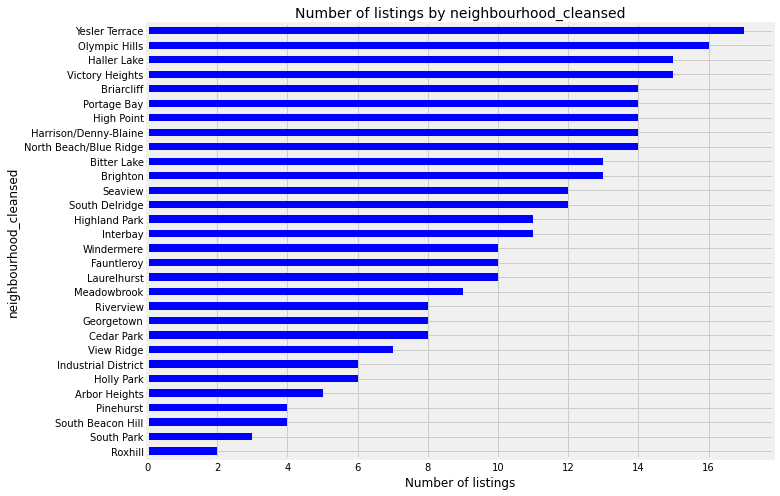

In [510]:
df_freq = listings_3['neighbourhood_cleansed'].value_counts().sort_values(ascending=True).head(30)
df_freq.plot.barh(figsize=(10,8), color ='b', width= 0.5)
plt.title('Number of listings by neighbourhood_cleansed', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('neighbourhood_cleansed', fontsize = 12)
plt.show()

In [511]:
listings_3.neighbourhood.unique()

array(['Queen Anne', nan, 'Ballard', 'Phinney Ridge', 'Fremont',
       'Lower Queen Anne', 'Westlake', 'Wallingford', 'Green Lake',
       'Minor', 'Madrona', 'Harrison/Denny-Blaine', 'Leschi',
       'University District', 'Roosevelt', 'Madison Park', 'Capitol Hill',
       'Atlantic', 'North Beacon Hill', 'Central Business District',
       'Pike Place Market', 'Pike Market', 'Eastlake', 'Portage Bay',
       'South Lake Union', 'Magnolia', 'Belltown',
       'International District', 'Yesler Terrace', 'First Hill',
       'Pioneer Square', 'Gatewood', 'The Junction', 'Arbor Heights',
       'Alki', 'North Admiral', 'Crown Hill', 'Genesee', 'Fairmount Park',
       'Interbay', 'Industrial District', 'Holly Park',
       'South Beacon Hill', 'Greenwood', 'Bitter Lake', 'Fauntleroy',
       'Mount Baker', 'Columbia City', 'Seward Park', 'Brighton',
       'South Delridge', 'Highland Park', 'High Point', 'View Ridge',
       'Windermere', 'Dunlap', 'Rainier Beach', 'North Delridge',
  

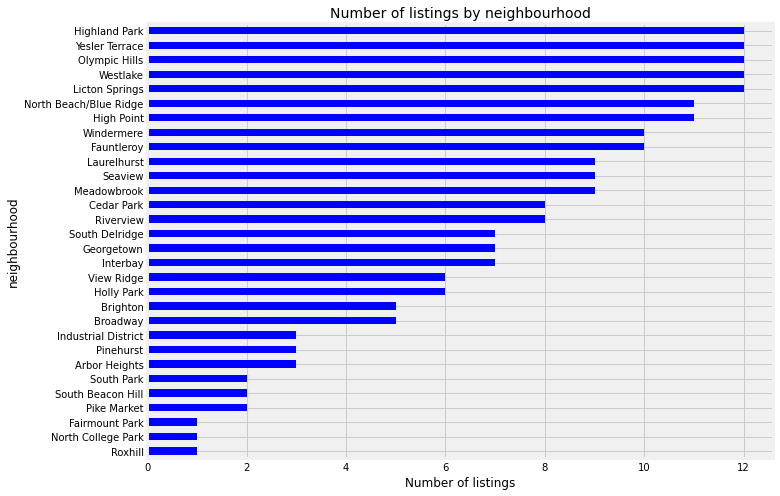

In [512]:
df_freq = listings_3['neighbourhood'].value_counts().sort_values(ascending=True).head(30)
df_freq.plot.barh(figsize=(10,8), color ='b', width= 0.5)
plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('neighbourhood', fontsize = 12)
plt.show()

In [513]:
listings_3.city.unique()

array(['Seattle', 'Ballard, Seattle', 'West Seattle', 'Seattle ', '西雅图',
       'Phinney Ridge Seattle', 'seattle'], dtype=object)

In [514]:
listings_3.city.value_counts()

Seattle                  3810
West Seattle                2
Seattle                     2
Phinney Ridge Seattle       1
seattle                     1
西雅图                         1
Ballard, Seattle            1
Name: city, dtype: int64

In [515]:
listings_3.market.unique()

array(['Seattle'], dtype=object)

In [516]:
listings_3.smart_location.unique()

array(['Seattle, WA', 'Ballard, Seattle, WA', 'West Seattle, WA',
       'Seattle , WA', '西雅图, WA', 'Phinney Ridge Seattle, WA',
       'seattle, wa'], dtype=object)

In [517]:
listings_3.smart_location.value_counts()

Seattle, WA                  3810
West Seattle, WA                2
Seattle , WA                    2
seattle, wa                     1
西雅图, WA                         1
Ballard, Seattle, WA            1
Phinney Ridge Seattle, WA       1
Name: smart_location, dtype: int64

In [518]:
listings_3.country_code.unique()

array(['US'], dtype=object)

In [519]:
listings_3.is_location_exact.value_counts()

t    3412
f     406
Name: is_location_exact, dtype: int64

In [520]:
listings_3.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

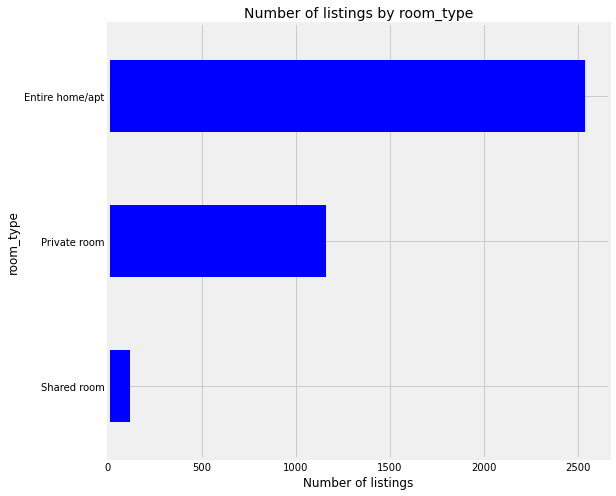

In [521]:
df_freq = listings_3.room_type.value_counts().sort_values(ascending=True).head(30)
df_freq.plot.barh(figsize=(8,8), color ='b', width= 0.5)
plt.title('Number of listings by room_type', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('room_type', fontsize = 12)
plt.show()

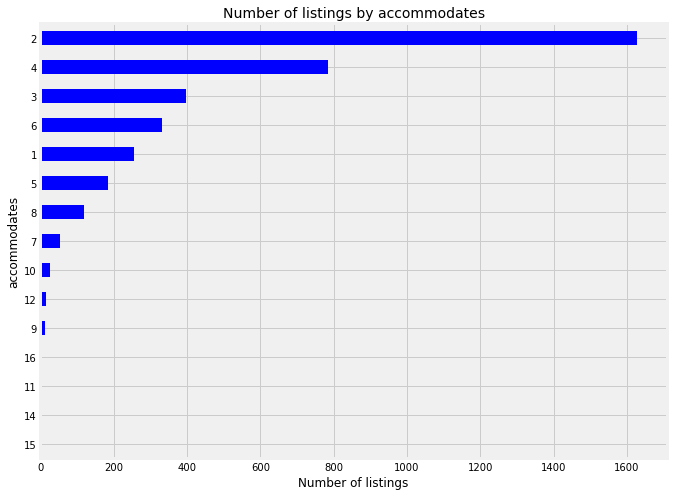

In [522]:
df_freq = listings_3.accommodates.value_counts().sort_values(ascending=True).head(100)
df_freq.plot.barh(figsize=(10,8), color ='b', width= 0.5)
plt.title('Number of listings by accommodates', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('accommodates', fontsize = 12)
plt.show()

* This category can be split into two:
1. 2 accommodates
2. more then 2 accommodates

In [523]:
listings_3['two_accomm'] = (listings_3['accommodates'] == 2).astype(int)
listings_3['more_then_two_accomm'] = (listings_3['accommodates'] > 2).astype(int)


Drop neighbourhood, neighbourhood_group_cleansed, neighbourhood_cleansed \
They are good for visual map appearances for initial observation 

In [524]:
listings_3.drop(['zipcode','smart_location','street','is_location_exact','neighbourhood',
                 'neighbourhood_group_cleansed','neighbourhood_cleansed','country_code',
                 'market','city','state','country','property_type'],axis=1,inplace=True)

In [525]:
listings_3 = pd.get_dummies(listings_3)

In [526]:
listings_3.head()

latitude   longitude  accommodates  property_type_house  \
0  47.636289 -122.371025             4                    0   
1  47.639123 -122.365666             4                    0   
2  47.629724 -122.369483            11                    1   
3  47.638473 -122.369279             3                    0   
4  47.632918 -122.372471             6                    1   

   property_type_apartment  property_type_others  two_accomm  \
0                        1                     0           0   
1                        1                     0           0   
2                        0                     0           0   
3                        1                     0           0   
4                        0                     0           0   

   more_then_two_accomm  room_type_Entire home/apt  room_type_Private room  \
0                     1                          1                       0   
1                     1                          1                       0   
2                     1                          1                       0   
3                     1                          1                       0   
4                     1                          1                       0   

   room_type_Shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

In [527]:
listings_3.isnull().sum()

latitude                     0
longitude                    0
accommodates                 0
property_type_house          0
property_type_apartment      0
property_type_others         0
two_accomm                   0
more_then_two_accomm         0
room_type_Entire home/apt    0
room_type_Private room       0
room_type_Shared room        0
dtype: int64

# Fourth part

In [528]:
listings_4 = listings[['bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability']].copy()
listings_4.head()

bathrooms  bedrooms  beds  bed_type  \
0        1.0       1.0   1.0  Real Bed   
1        1.0       1.0   1.0  Real Bed   
2        4.5       5.0   7.0  Real Bed   
3        1.0       0.0   2.0  Real Bed   
4        2.0       3.0   3.0  Real Bed   

                                           amenities  square_feet  price  \
0  {TV,"Cable TV",Internet,"Wireless Internet","A...          NaN   85.0   
1  {TV,Internet,"Wireless Internet",Kitchen,"Free...          NaN  150.0   
2  {TV,"Cable TV",Internet,"Wireless Internet","A...          NaN  975.0   
3  {Internet,"Wireless Internet",Kitchen,"Indoor ...          NaN  100.0   
4  {TV,"Cable TV",Internet,"Wireless Internet",Ki...          NaN  450.0   

   weekly_price  monthly_price  security_deposit  cleaning_fee  \
0           NaN            NaN               NaN           NaN   
1        1000.0         3000.0             100.0          40.0   
2           NaN            NaN            1000.0         300.0   
3         650.0         2300.0               NaN           NaN   
4           NaN            NaN             700.0         125.0   

   guests_included  extra_people  minimum_nights  maximum_nights  \
0                2           5.0               1             365   
1                1           0.0               2              90   
2               10          25.0               4              30   
3                1           0.0               1            1125   
4                6          15.0               1            1125   

  calendar_updated has_availability  
0      4 weeks ago                t  
1            today                t  
2      5 weeks ago                t  
3     6 months ago                t  
4      7 weeks ago                t

In [529]:
listings_4.isnull().sum()

bathrooms             16
bedrooms               6
beds                   1
bed_type               0
amenities              0
square_feet         3721
price                  0
weekly_price        1809
monthly_price       2301
security_deposit    1952
cleaning_fee        1030
guests_included        0
extra_people           0
minimum_nights         0
maximum_nights         0
calendar_updated       0
has_availability       0
dtype: int64

In [530]:
listings_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bathrooms         3802 non-null   float64
 1   bedrooms          3812 non-null   float64
 2   beds              3817 non-null   float64
 3   bed_type          3818 non-null   object 
 4   amenities         3818 non-null   object 
 5   square_feet       97 non-null     float64
 6   price             3818 non-null   float64
 7   weekly_price      2009 non-null   float64
 8   monthly_price     1517 non-null   float64
 9   security_deposit  1866 non-null   float64
 10  cleaning_fee      2788 non-null   float64
 11  guests_included   3818 non-null   int64  
 12  extra_people      3818 non-null   float64
 13  minimum_nights    3818 non-null   int64  
 14  maximum_nights    3818 non-null   int64  
 15  calendar_updated  3818 non-null   object 
 16  has_availability  3818 non-null   object 


In [531]:
listings_4['has_availability'] = listings_4['has_availability'].replace('f', 0)
listings_4['has_availability'] = listings_4['has_availability'].replace('t', 1)

<AxesSubplot:>

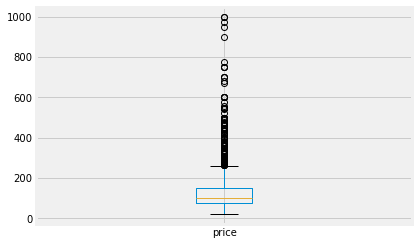

In [532]:
listings_4.price.plot(kind='box')

In [533]:
listings_4.price.describe()
# we will use 600 as max price to avoid outliers above

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

<AxesSubplot:>

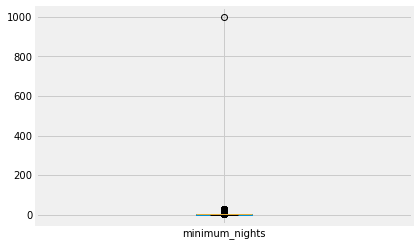

In [534]:
listings_4.minimum_nights.plot(kind='box')
# We have outlier in 1000 value
# This is wrong value, we will remove it in the last part

In [535]:
listings_4.minimum_nights.describe()
# we will use 200 value as max

count    3818.000000
mean        2.369303
std        16.305902
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max      1000.000000
Name: minimum_nights, dtype: float64

<AxesSubplot:>

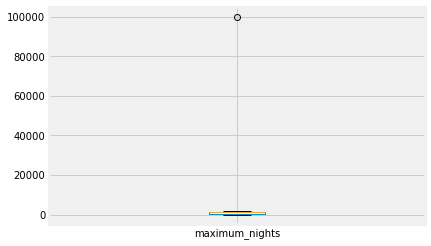

In [536]:
listings_4.maximum_nights.plot(kind='box')
# We have outlier in 100000 value
# This is wrong value we will remove it in the last part

In [537]:
listings_4.maximum_nights.describe()
# we will use 1200 value as max

count      3818.000000
mean        780.447617
std        1683.589007
min           1.000000
25%          60.000000
50%        1125.000000
75%        1125.000000
max      100000.000000
Name: maximum_nights, dtype: float64

<AxesSubplot:>

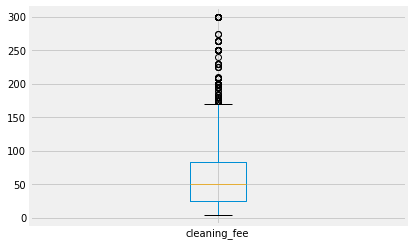

In [538]:
listings_4.cleaning_fee.plot(kind='box')

In [539]:
listings_4.cleaning_fee.describe()
# It is hard to tell outliers here, many values are above the Maximum 
# This can be due to very pricey hosts that level the price up

count    2788.000000
mean       61.710904
std        48.830341
min         5.000000
25%        25.000000
50%        50.000000
75%        83.000000
max       300.000000
Name: cleaning_fee, dtype: float64

<AxesSubplot:>

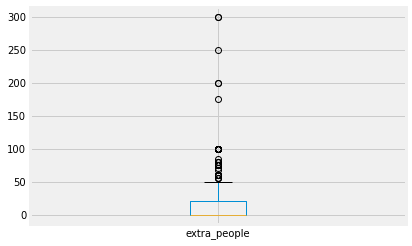

In [540]:
listings_4.extra_people.plot(kind='box')

In [541]:
listings_4.extra_people.describe()
# We will use the 100 value as a max

count    3818.000000
mean       10.667627
std        17.585922
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max       300.000000
Name: extra_people, dtype: float64

<AxesSubplot:>

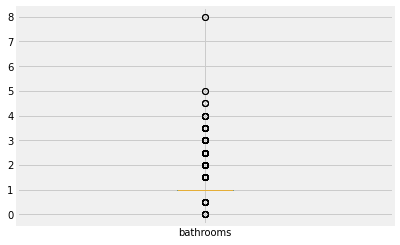

In [542]:
listings_4.bathrooms.plot(kind='box')

In [543]:
listings_4.bathrooms.describe()
# we will remove the 8 value 

count    3802.000000
mean        1.259469
std         0.590369
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
Name: bathrooms, dtype: float64

<AxesSubplot:>

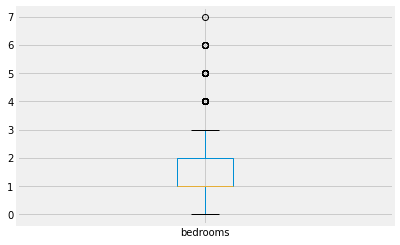

In [544]:
listings_4.bedrooms.plot(kind='box')

In [545]:
listings_4.bedrooms.describe()

count    3812.000000
mean        1.307712
std         0.883395
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: bedrooms, dtype: float64

<AxesSubplot:>

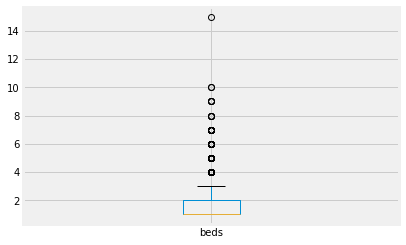

In [546]:
listings_4.beds.plot(kind='box')

In [547]:
listings_4.beds.describe()
# We will remove the 15 value

count    3817.000000
mean        1.735394
std         1.139480
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        15.000000
Name: beds, dtype: float64

<AxesSubplot:>

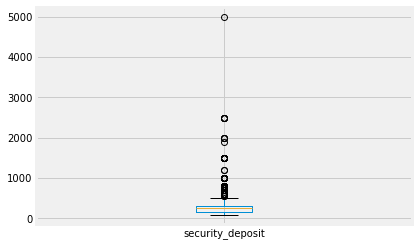

In [548]:
listings_4.security_deposit.plot(kind='box')

In [549]:
listings_4.security_deposit.describe()
# we will take the 2000 as upper limit

count    1866.000000
mean      287.610397
std       270.222690
min        95.000000
25%       150.000000
50%       250.000000
75%       300.000000
max      5000.000000
Name: security_deposit, dtype: float64

In [550]:
listings_4.bed_type.unique()

array(['Real Bed', 'Futon', 'Pull-out Sofa', 'Airbed', 'Couch'],
      dtype=object)

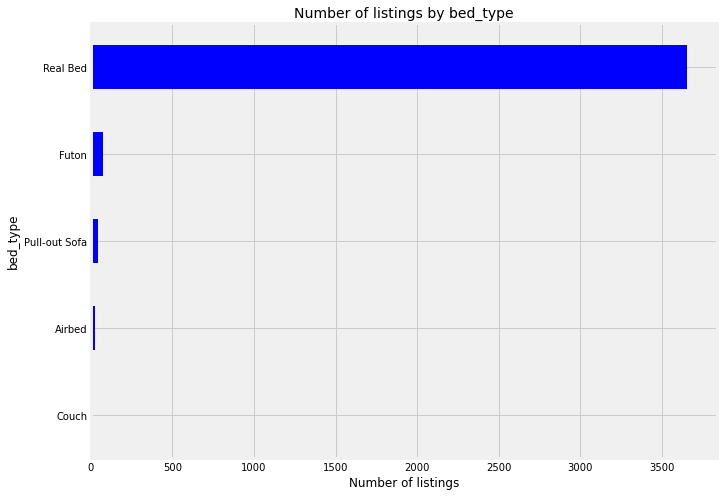

In [551]:
df_freq = listings_4.bed_type.value_counts().sort_values(ascending=True).head(100)
df_freq.plot.barh(figsize=(10,8), color ='b', width= 0.5)
plt.title('Number of listings by bed_type', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('bed_type', fontsize = 12)
plt.show()

In [552]:
# we will create new columns that seperate the data into Real Bed/others
listings_4['bed_type_real_bed'] = ((listings_4.bed_type == 'Real Bed')).astype(int)
listings_4['bed_type_others'] = ((listings_4.bed_type != 'Real Bed')).astype(int)

<AxesSubplot:>

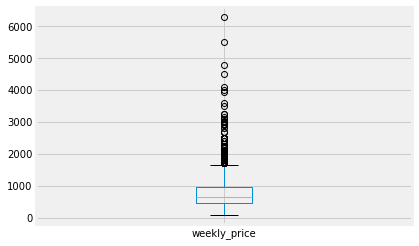

In [553]:
listings_4.weekly_price.plot(kind='box')

In [554]:
listings_4.weekly_price.describe()
# We will use the 4000 as upper limit

count    2009.000000
mean      788.481832
std       532.352269
min       100.000000
25%       455.000000
50%       650.000000
75%       950.000000
max      6300.000000
Name: weekly_price, dtype: float64

<AxesSubplot:>

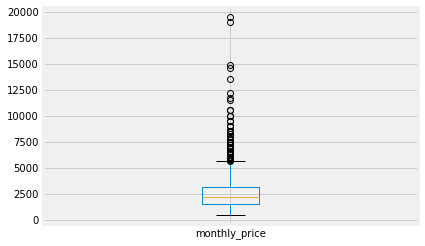

In [555]:
listings_4.monthly_price.plot(kind='box')

In [556]:
listings_4.monthly_price.describe()
# We will use the 12500 as upper limit

count     1517.000000
mean      2613.336190
std       1722.267981
min        500.000000
25%       1512.000000
50%       2200.000000
75%       3150.000000
max      19500.000000
Name: monthly_price, dtype: float64

* Replace all NaN with Mean following the distribution results above

In [557]:
cols = ['bathrooms','bedrooms','beds','weekly_price','monthly_price','security_deposit','cleaning_fee']
for col in cols:
    listings_4[col] = listings_4[col].replace(0.0, listings_4[col].mean())
    listings_4[col] = listings_4[col].replace(np.nan, listings_4[col].mean())
listings_4.head()

bathrooms  bedrooms  beds  bed_type  \
0        1.0  1.000000   1.0  Real Bed   
1        1.0  1.000000   1.0  Real Bed   
2        4.5  5.000000   7.0  Real Bed   
3        1.0  1.307712   2.0  Real Bed   
4        2.0  3.000000   3.0  Real Bed   

                                           amenities  square_feet  price  \
0  {TV,"Cable TV",Internet,"Wireless Internet","A...          NaN   85.0   
1  {TV,Internet,"Wireless Internet",Kitchen,"Free...          NaN  150.0   
2  {TV,"Cable TV",Internet,"Wireless Internet","A...          NaN  975.0   
3  {Internet,"Wireless Internet",Kitchen,"Indoor ...          NaN  100.0   
4  {TV,"Cable TV",Internet,"Wireless Internet",Ki...          NaN  450.0   

   weekly_price  monthly_price  security_deposit  cleaning_fee  \
0    788.481832     2613.33619        287.610397     61.710904   
1   1000.000000     3000.00000        100.000000     40.000000   
2    788.481832     2613.33619       1000.000000    300.000000   
3    650.000000     2300.00000        287.610397     61.710904   
4    788.481832     2613.33619        700.000000    125.000000   

   guests_included  extra_people  minimum_nights  maximum_nights  \
0                2           5.0               1             365   
1                1           0.0               2              90   
2               10          25.0               4              30   
3                1           0.0               1            1125   
4                6          15.0               1            1125   

  calendar_updated  has_availability  bed_type_real_bed  bed_type_others  
0      4 weeks ago                 1                  1                0  
1            today                 1                  1                0  
2      5 weeks ago                 1                  1                0  
3     6 months ago                 1                  1                0  
4      7 weeks ago                 1                  1                0

In [558]:
listings_4.calendar_updated.unique()

array(['4 weeks ago', 'today', '5 weeks ago', '6 months ago',
       '7 weeks ago', '2 weeks ago', 'yesterday', '5 months ago',
       'a week ago', '5 days ago', '3 days ago', '2 months ago',
       '3 months ago', '4 days ago', '2 days ago', '3 weeks ago',
       '1 week ago', '13 months ago', '6 weeks ago', '8 months ago',
       '12 months ago', '4 months ago', 'never', '6 days ago',
       '10 months ago', '14 months ago', '9 months ago', '7 months ago',
       '30 months ago', '11 months ago', '22 months ago', '16 months ago',
       '15 months ago', '17 months ago'], dtype=object)

* Too many distinct values for hot encoding \
We are collecting the date in another feature \
drop this columns

Amenities can be addressed either quantity or quality \
We can count how much values there is in any case, \
or we can segment the appearances by importance Vs price \
In this stage we will use the first approach

In [559]:
import re
final_list = []
listings_4['amen_list'] = listings_4['amenities'].copy()
list_1 = listings_4.amenities.copy()
list_of_chars = ['"',',','{', '}']
# Create regex pattern to match all characters in list
pattern = '[' +  ''.join(list_of_chars) +  ']'
for index in range(len(list_1)):
    # Remove multiple characters from the string
    sample_str = re.sub(pattern, '', list_1[index])
    sample_str = sample_str.split()
    final_list.append(sample_str)

for index in range(len(final_list)):
    listings_4['amen_list'][index] = len(final_list[index])

listings_4['amen_list'] = listings_4['amen_list'].astype(int)
listings_4.head()

<ipython-input-559-a88a55d28e93>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_4['amen_list'][index] = len(final_list[index])


bathrooms  bedrooms  beds  bed_type  \
0        1.0  1.000000   1.0  Real Bed   
1        1.0  1.000000   1.0  Real Bed   
2        4.5  5.000000   7.0  Real Bed   
3        1.0  1.307712   2.0  Real Bed   
4        2.0  3.000000   3.0  Real Bed   

                                           amenities  square_feet  price  \
0  {TV,"Cable TV",Internet,"Wireless Internet","A...          NaN   85.0   
1  {TV,Internet,"Wireless Internet",Kitchen,"Free...          NaN  150.0   
2  {TV,"Cable TV",Internet,"Wireless Internet","A...          NaN  975.0   
3  {Internet,"Wireless Internet",Kitchen,"Indoor ...          NaN  100.0   
4  {TV,"Cable TV",Internet,"Wireless Internet",Ki...          NaN  450.0   

   weekly_price  monthly_price  security_deposit  cleaning_fee  \
0    788.481832     2613.33619        287.610397     61.710904   
1   1000.000000     3000.00000        100.000000     40.000000   
2    788.481832     2613.33619       1000.000000    300.000000   
3    650.000000     2300.00000        287.610397     61.710904   
4    788.481832     2613.33619        700.000000    125.000000   

   guests_included  extra_people  minimum_nights  maximum_nights  \
0                2           5.0               1             365   
1                1           0.0               2              90   
2               10          25.0               4              30   
3                1           0.0               1            1125   
4                6          15.0               1            1125   

  calendar_updated  has_availability  bed_type_real_bed  bed_type_others  \
0      4 weeks ago                 1                  1                0   
1            today                 1                  1                0   
2      5 weeks ago                 1                  1                0   
3     6 months ago                 1                  1                0   
4      7 weeks ago                 1                  1                0   

   amen_list  
0          5  
1         14  
2         18  
3          9  
4         10

In [560]:
listings_4.drop(['square_feet','bed_type','calendar_updated','amenities'], axis=1,inplace=True)

In [561]:
listings_4.head()

bathrooms  bedrooms  beds  price  weekly_price  monthly_price  \
0        1.0  1.000000   1.0   85.0    788.481832     2613.33619   
1        1.0  1.000000   1.0  150.0   1000.000000     3000.00000   
2        4.5  5.000000   7.0  975.0    788.481832     2613.33619   
3        1.0  1.307712   2.0  100.0    650.000000     2300.00000   
4        2.0  3.000000   3.0  450.0    788.481832     2613.33619   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0        287.610397     61.710904                2           5.0   
1        100.000000     40.000000                1           0.0   
2       1000.000000    300.000000               10          25.0   
3        287.610397     61.710904                1           0.0   
4        700.000000    125.000000                6          15.0   

   minimum_nights  maximum_nights  has_availability  bed_type_real_bed  \
0               1             365                 1                  1   
1               2              90                 1                  1   
2               4              30                 1                  1   
3               1            1125                 1                  1   
4               1            1125                 1                  1   

   bed_type_others  amen_list  
0                0          5  
1                0         14  
2                0         18  
3                0          9  
4                0         10

In [562]:
listings_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathrooms          3818 non-null   float64
 1   bedrooms           3818 non-null   float64
 2   beds               3818 non-null   float64
 3   price              3818 non-null   float64
 4   weekly_price       3818 non-null   float64
 5   monthly_price      3818 non-null   float64
 6   security_deposit   3818 non-null   float64
 7   cleaning_fee       3818 non-null   float64
 8   guests_included    3818 non-null   int64  
 9   extra_people       3818 non-null   float64
 10  minimum_nights     3818 non-null   int64  
 11  maximum_nights     3818 non-null   int64  
 12  has_availability   3818 non-null   int64  
 13  bed_type_real_bed  3818 non-null   int32  
 14  bed_type_others    3818 non-null   int32  
 15  amen_list          3818 non-null   int32  
dtypes: float64(9), int32(3),

In [563]:
listings_4.isnull().sum()

bathrooms            0
bedrooms             0
beds                 0
price                0
weekly_price         0
monthly_price        0
security_deposit     0
cleaning_fee         0
guests_included      0
extra_people         0
minimum_nights       0
maximum_nights       0
has_availability     0
bed_type_real_bed    0
bed_type_others      0
amen_list            0
dtype: int64

# Fifth part

In [575]:
listings_5 = listings[['availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication']].copy()
listings_5.head()

availability_30  availability_60  availability_90  availability_365  \
0               14               41               71               346   
1               13               13               16               291   
2                1                6               17               220   
3                0                0                0               143   
4               30               60               90               365   

  calendar_last_scraped  number_of_reviews first_review last_review  \
0            2016-01-04                207   2011-11-01  2016-01-02   
1            2016-01-04                 43   2013-08-19  2015-12-29   
2            2016-01-04                 20   2014-07-30  2015-09-03   
3            2016-01-04                  0          NaN         NaN   
4            2016-01-04                 38   2012-07-10  2015-10-24   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  95.0                    10.0                       10.0   
1                  96.0                    10.0                       10.0   
2                  97.0                    10.0                       10.0   
3                   NaN                     NaN                        NaN   
4                  92.0                     9.0                        9.0   

   review_scores_checkin  review_scores_communication  
0                   10.0                         10.0  
1                   10.0                         10.0  
2                   10.0                         10.0  
3                    NaN                          NaN  
4                   10.0                         10.0

In [576]:
listings_5.isnull().sum()

availability_30                  0
availability_60                  0
availability_90                  0
availability_365                 0
calendar_last_scraped            0
number_of_reviews                0
first_review                   627
last_review                    627
review_scores_rating           647
review_scores_accuracy         658
review_scores_cleanliness      653
review_scores_checkin          658
review_scores_communication    651
dtype: int64

In [577]:
listings_5.head()

availability_30  availability_60  availability_90  availability_365  \
0               14               41               71               346   
1               13               13               16               291   
2                1                6               17               220   
3                0                0                0               143   
4               30               60               90               365   

  calendar_last_scraped  number_of_reviews first_review last_review  \
0            2016-01-04                207   2011-11-01  2016-01-02   
1            2016-01-04                 43   2013-08-19  2015-12-29   
2            2016-01-04                 20   2014-07-30  2015-09-03   
3            2016-01-04                  0          NaN         NaN   
4            2016-01-04                 38   2012-07-10  2015-10-24   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  95.0                    10.0                       10.0   
1                  96.0                    10.0                       10.0   
2                  97.0                    10.0                       10.0   
3                   NaN                     NaN                        NaN   
4                  92.0                     9.0                        9.0   

   review_scores_checkin  review_scores_communication  
0                   10.0                         10.0  
1                   10.0                         10.0  
2                   10.0                         10.0  
3                    NaN                          NaN  
4                   10.0                         10.0

In [578]:
listings_5.describe()

availability_30  availability_60  availability_90  availability_365  \
count      3818.000000      3818.000000      3818.000000       3818.000000   
mean         16.786276        36.814825        58.082504        244.772656   
std          12.173637        23.337541        34.063845        126.772526   
min           0.000000         0.000000         0.000000          0.000000   
25%           2.000000        13.000000        28.000000        124.000000   
50%          20.000000        46.000000        73.000000        308.000000   
75%          30.000000        59.000000        89.000000        360.000000   
max          30.000000        60.000000        90.000000        365.000000   

       number_of_reviews  review_scores_rating  review_scores_accuracy  \
count        3818.000000           3171.000000             3160.000000   
mean           22.223415             94.539262                9.636392   
std            37.730892              6.606083                0.698031   
min             0.000000             20.000000                2.000000   
25%             2.000000             93.000000                9.000000   
50%             9.000000             96.000000               10.000000   
75%            26.000000             99.000000               10.000000   
max           474.000000            100.000000               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                3165.000000            3160.000000   
mean                    9.556398               9.786709   
std                     0.797274               0.595499   
min                     3.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  
count                  3167.000000  
mean                      9.809599  
std                       0.568211  
min                       2.000000  
25%                      10.000000  
50%                      10.000000  
75%                      10.000000  
max                      10.000000

* Replacing Nan with mean in:review_scores_rating, review_scores_accuracy, review_scores_cleanliness,
  review_scores_checkin,  review_scores_communication.
 The distribution is toward the max (tailed), so we can set Nan to the mean without distorting the data

In [579]:
cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin','review_scores_communication']
for col in cols:
    listings_5[col] = listings_5[col].replace(np.nan, listings_5[col].mean())


In [580]:
listings_5['last_review'] = listings_5['last_review'].replace(np.nan, '2016-01-04')
listings_5['first_review'] = listings_5['first_review'].replace(np.nan, '2016-01-04')
listings_5['last_review'] = pd.to_datetime(listings_5['last_review'])
listings_5['first_review'] = pd.to_datetime(listings_5['first_review'])
listings_5['days_past_last_review'] = listings_5['last_review'] - listings_5['first_review']

* We will use the [last_review,first_review] pair to create a new feature that calculate the days_past_last_review
This will tell us how long the host is present. New hosts that are NaN will get 0 value, or other host thet was not review yet. this way we are not deleting rows with NaN.
We will convert the results to int (days representation)

In [581]:
listings_5['days_past_last_review'] = listings_5['days_past_last_review'].astype('timedelta64[s]')/(24*60*60)
listings_5['days_past_last_review']

0       1523.0
1        862.0
2        400.0
3          0.0
4       1201.0
         ...  
3813       0.0
3814       6.0
3815       0.0
3816       0.0
3817       0.0
Name: days_past_last_review, Length: 3818, dtype: float64

In [586]:
listings_5.drop(['first_review','last_review','availability_30','availability_60',
                 'availability_90','availability_365','calendar_last_scraped'],axis=1,inplace=True)

In [587]:
listings_5.head()

number_of_reviews  review_scores_rating  review_scores_accuracy  \
0                207             95.000000               10.000000   
1                 43             96.000000               10.000000   
2                 20             97.000000               10.000000   
3                  0             94.539262                9.636392   
4                 38             92.000000                9.000000   

   review_scores_cleanliness  review_scores_checkin  \
0                  10.000000              10.000000   
1                  10.000000              10.000000   
2                  10.000000              10.000000   
3                   9.556398               9.786709   
4                   9.000000              10.000000   

   review_scores_communication  days_past_last_review  
0                    10.000000                 1523.0  
1                    10.000000                  862.0  
2                    10.000000                  400.0  
3                     9.809599                    0.0  
4                    10.000000                 1201.0

In [588]:
listings_5.isnull().sum()

number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
days_past_last_review          0
dtype: int64

In [589]:
listings_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   number_of_reviews            3818 non-null   int64  
 1   review_scores_rating         3818 non-null   float64
 2   review_scores_accuracy       3818 non-null   float64
 3   review_scores_cleanliness    3818 non-null   float64
 4   review_scores_checkin        3818 non-null   float64
 5   review_scores_communication  3818 non-null   float64
 6   days_past_last_review        3818 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 208.9 KB


# Sixth part

In [590]:
listings_6 = listings[['review_scores_location', 'review_scores_value', 'requires_license',
       'license', 'jurisdiction_names', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month']].copy()
listings_6.head()

review_scores_location  review_scores_value requires_license  license  \
0                     9.0                 10.0                f      NaN   
1                    10.0                 10.0                f      NaN   
2                    10.0                 10.0                f      NaN   
3                     NaN                  NaN                f      NaN   
4                     9.0                  9.0                f      NaN   

  jurisdiction_names instant_bookable cancellation_policy  \
0         WASHINGTON                f            moderate   
1         WASHINGTON                f              strict   
2         WASHINGTON                f              strict   
3         WASHINGTON                f            flexible   
4         WASHINGTON                f              strict   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             t                                t   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  reviews_per_month  
0                               2               4.07  
1                               6               1.48  
2                               2               1.15  
3                               1                NaN  
4                               1               0.89

In [591]:
listings_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   review_scores_location            3163 non-null   float64
 1   review_scores_value               3162 non-null   float64
 2   requires_license                  3818 non-null   object 
 3   license                           0 non-null      float64
 4   jurisdiction_names                3818 non-null   object 
 5   instant_bookable                  3818 non-null   object 
 6   cancellation_policy               3818 non-null   object 
 7   require_guest_profile_picture     3818 non-null   object 
 8   require_guest_phone_verification  3818 non-null   object 
 9   calculated_host_listings_count    3818 non-null   int64  
 10  reviews_per_month                 3191 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 328.2+ KB


In [592]:
listings_6.isnull().sum()

review_scores_location               655
review_scores_value                  656
requires_license                       0
license                             3818
jurisdiction_names                     0
instant_bookable                       0
cancellation_policy                    0
require_guest_profile_picture          0
require_guest_phone_verification       0
calculated_host_listings_count         0
reviews_per_month                    627
dtype: int64

In [593]:
listings_6.jurisdiction_names.value_counts()

WASHINGTON    3818
Name: jurisdiction_names, dtype: int64

In [594]:
listings_6.require_guest_profile_picture.value_counts()

f    3497
t     321
Name: require_guest_profile_picture, dtype: int64

In [595]:
listings_6.require_guest_phone_verification.value_counts()

f    3443
t     375
Name: require_guest_phone_verification, dtype: int64

In [596]:
listings_6.instant_bookable.value_counts()

f    3227
t     591
Name: instant_bookable, dtype: int64

In [599]:
cols = ['instant_bookable', 'require_guest_profile_picture','require_guest_phone_verification']
for col in cols:
    listings_6[col] = listings_6[col].replace('f', 0)
    listings_6[col] = listings_6[col].replace('t', 1)

<AxesSubplot:>

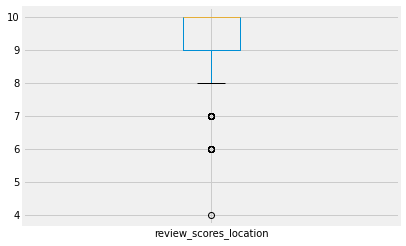

In [600]:
listings_6.review_scores_location.plot(kind='box')

In [601]:
listings_6.review_scores_location.describe()

count    3163.000000
mean        9.608916
std         0.629053
min         4.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: review_scores_location, dtype: float64

<AxesSubplot:>

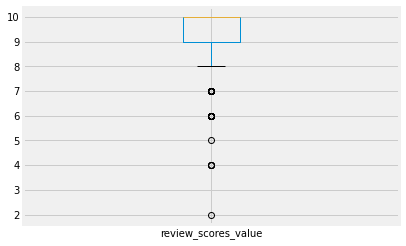

In [602]:
listings_6.review_scores_value.plot(kind='box')

In [603]:
listings_6.review_scores_value.describe()

count    3162.000000
mean        9.452245
std         0.750259
min         2.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: review_scores_value, dtype: float64

In [604]:
listings_6.reviews_per_month.describe()

count    3191.000000
mean        2.078919
std         1.822348
min         0.020000
25%         0.695000
50%         1.540000
75%         3.000000
max        12.150000
Name: reviews_per_month, dtype: float64

* We will replace all null values with the mean() in the following:review_scores_location, review_scores_value, reviews_per_month. Looking at the distribution the mean is a good approx

In [605]:
cols = ['review_scores_location','review_scores_value','reviews_per_month']
for col in cols:
    listings_6[col] = listings_6[col].replace(np.nan, listings_6[col].mean())

Collecting all parts to one DF

In [606]:
listings_6.drop(['requires_license','license','jurisdiction_names'],axis=1, inplace=True)


* Create dummies


In [607]:
listings_6 = pd.get_dummies(listings_6)

In [608]:
listings_6.head()

review_scores_location  review_scores_value  \
0                9.000000            10.000000   
1               10.000000            10.000000   
2               10.000000            10.000000   
3                9.608916             9.452245   
4                9.000000             9.000000   

   calculated_host_listings_count  reviews_per_month  instant_bookable_0  \
0                               2           4.070000                   1   
1                               6           1.480000                   1   
2                               2           1.150000                   1   
3                               1           2.078919                   1   
4                               1           0.890000                   1   

   instant_bookable_1  cancellation_policy_flexible  \
0                   0                             0   
1                   0                             0   
2                   0                             0   
3                   0                             1   
4                   0                             0   

   cancellation_policy_moderate  cancellation_policy_strict  \
0                             1                           0   
1                             0                           1   
2                             0                           1   
3                             0                           0   
4                             0                           1   

   require_guest_profile_picture_0  require_guest_profile_picture_1  \
0                                1                                0   
1                                0                                1   
2                                1                                0   
3                                1                                0   
4                                1                                0   

   require_guest_phone_verification_0  require_guest_phone_verification_1  
0                                   1                                   0  
1                                   0                                   1  
2                                   1                                   0  
3                                   1                                   0  
4                                   1                                   0

In [610]:
listings_6.isnull().sum()

review_scores_location                0
review_scores_value                   0
calculated_host_listings_count        0
reviews_per_month                     0
instant_bookable_0                    0
instant_bookable_1                    0
cancellation_policy_flexible          0
cancellation_policy_moderate          0
cancellation_policy_strict            0
require_guest_profile_picture_0       0
require_guest_profile_picture_1       0
require_guest_phone_verification_0    0
require_guest_phone_verification_1    0
dtype: int64

In [611]:
listings_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   review_scores_location              3818 non-null   float64
 1   review_scores_value                 3818 non-null   float64
 2   calculated_host_listings_count      3818 non-null   int64  
 3   reviews_per_month                   3818 non-null   float64
 4   instant_bookable_0                  3818 non-null   uint8  
 5   instant_bookable_1                  3818 non-null   uint8  
 6   cancellation_policy_flexible        3818 non-null   uint8  
 7   cancellation_policy_moderate        3818 non-null   uint8  
 8   cancellation_policy_strict          3818 non-null   uint8  
 9   require_guest_profile_picture_0     3818 non-null   uint8  
 10  require_guest_profile_picture_1     3818 non-null   uint8  
 11  require_guest_phone_verification_0  3818 no

In [612]:
df_list = [listings_6,listings_5,listings_4,listings_3,listings_2,listings_1]
listings_short = pd.concat(df_list, axis=1)
listings_short.shape


(3818, 55)

In [613]:
listings_short.head()

review_scores_location  review_scores_value  \
0                9.000000            10.000000   
1               10.000000            10.000000   
2               10.000000            10.000000   
3                9.608916             9.452245   
4                9.000000             9.000000   

   calculated_host_listings_count  reviews_per_month  instant_bookable_0  \
0                               2           4.070000                   1   
1                               6           1.480000                   1   
2                               2           1.150000                   1   
3                               1           2.078919                   1   
4                               1           0.890000                   1   

   instant_bookable_1  cancellation_policy_flexible  \
0                   0                             0   
1                   0                             0   
2                   0                             0   
3                   0                             1   
4                   0                             0   

   cancellation_policy_moderate  cancellation_policy_strict  \
0                             1                           0   
1                             0                           1   
2                             0                           1   
3                             0                           0   
4                             0                           1   

   require_guest_profile_picture_0  ...  room_type_Private room  \
0                                1  ...                       0   
1                                0  ...                       0   
2                                1  ...                       0   
3                                1  ...                       0   
4                                1  ...                       0   

   room_type_Shared room  host_response_rate  host_acceptance_rate  \
0                      0           96.000000            100.000000   
1                      0           98.000000            100.000000   
2                      0           67.000000            100.000000   
3                      0           81.888947             79.727606   
4                      0          100.000000             79.727606   

   host_is_superhost  host_listings_count  host_identity_verified  \
0                  0                  3.0                       1   
1                  1                  6.0                       1   
2                  0                  2.0                       1   
3                  0                  1.0                       1   
4                  0                  2.0                       1   

   Seniority_days  Seattle_location  Others_location  
0          1607.0                 1                0  
1          1047.0                 1                0  
2           571.0                 1                0  
3           789.0                 1                0  
4          1497.0                 1                0  

[5 rows x 55 columns]

In [615]:
listings_short.columns

Index(['review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'instant_bookable_0', 'instant_bookable_1',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'require_guest_profile_picture_0',
       'require_guest_profile_picture_1', 'require_guest_phone_verification_0',
       'require_guest_phone_verification_1', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'days_past_last_review', 'bathrooms',
       'bedrooms', 'beds', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'bed_type_real_bed', 'bed_type_others', 'amen_list', 'latitude',
       'longitude', 'accommodates', 'property_type_house',
       


* removing outliers


In [616]:
# Removing price  > 500
listings_short.drop(listings_short[listings_short.price > 500].index, inplace=True)
# Removing extra people >= 100
listings_short.drop(listings_short[listings_short.extra_people >= 100].index, inplace=True)
# Removing maximum night >= 1200
listings_short.drop(listings_short[listings_short.maximum_nights >= 1200].index, inplace =True)
# Removing minimum night >= 200
listings_short.drop(listings_short[listings_short.minimum_nights >= 200].index, inplace =True)
# Removing monthly price  > 6000
listings_short.drop(listings_short[listings_short.monthly_price > 6000].index, inplace =True)
# Removing beds > 10
listings_short.drop(listings_short[listings_short.beds > 10].index, inplace =True)
# Removing bathrooms > 5
listings_short.drop(listings_short[listings_short.bathrooms >= 5].index, inplace =True)
# We will use 4000 as upper limit
listings_short.drop(listings_short[listings_short.weekly_price >= 4000].index, inplace =True)
# We will use 12500 as upper limit
listings_short.drop(listings_short[listings_short.monthly_price >= 12500].index, inplace =True)
# We will use 2000 as upper limit
listings_short.drop(listings_short[listings_short.security_deposit >= 2000].index, inplace =True)
# We will use 12 as upper limit
listings_short.drop(listings_short[listings_short.accommodates >= 12].index, inplace =True)
# We will use 200 as upper limit
listings_short.drop(listings_short[listings_short.host_listings_count >= 200].index, inplace =True)



# Question 2:  Exploratory Data Analysis
1. Given your objective,  explore your data. Your main goal is to present some valuable insights coming from the dataset.
* Upon checking BOTH datasets, do you think you can add some valuble insight regarding the price?
* What else can you say about the data, which might help to better understand the problem?

array([[<AxesSubplot:title={'center':'review_scores_location'}>,
        <AxesSubplot:title={'center':'review_scores_value'}>,
        <AxesSubplot:title={'center':'calculated_host_listings_count'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>,
        <AxesSubplot:title={'center':'instant_bookable_0'}>,
        <AxesSubplot:title={'center':'instant_bookable_1'}>,
        <AxesSubplot:title={'center':'cancellation_policy_flexible'}>],
       [<AxesSubplot:title={'center':'cancellation_policy_moderate'}>,
        <AxesSubplot:title={'center':'cancellation_policy_strict'}>,
        <AxesSubplot:title={'center':'require_guest_profile_picture_0'}>,
        <AxesSubplot:title={'center':'require_guest_profile_picture_1'}>,
        <AxesSubplot:title={'center':'require_guest_phone_verification_0'}>,
        <AxesSubplot:title={'center':'require_guest_phone_verification_1'}>,
        <AxesSubplot:title={'center':'number_of_reviews'}>],
       [<AxesSubplot:title={'center':'revie

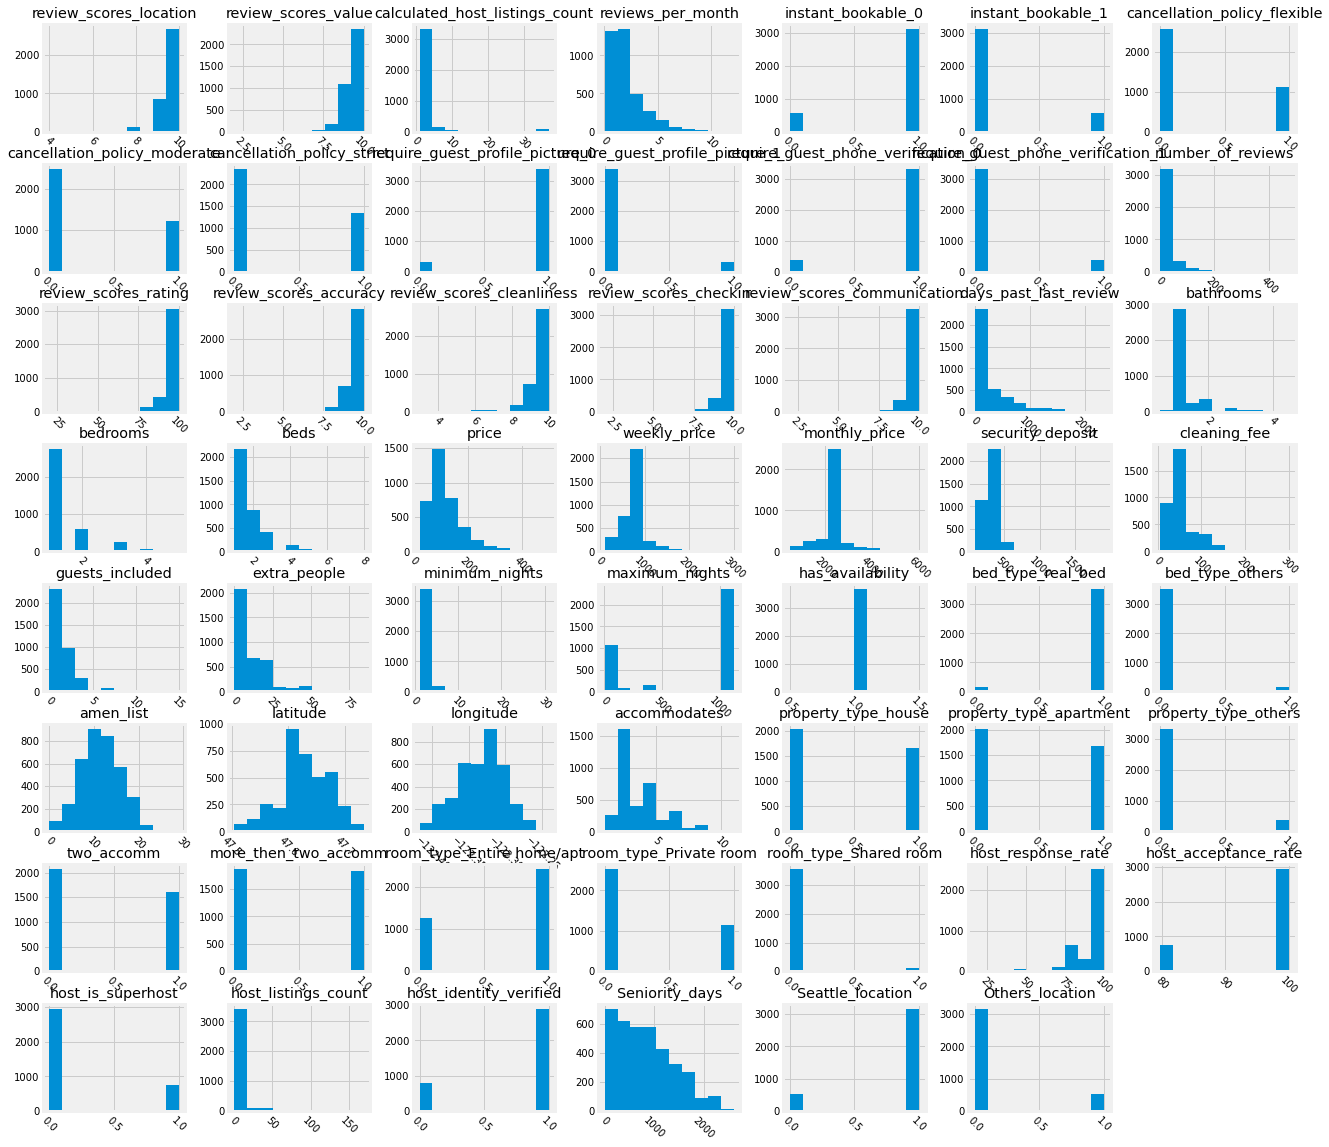

In [617]:
listings_short.hist(figsize=(20,20), xrot=-45)

In [618]:
listings_short.dtypes[listings_short.dtypes!='object']

review_scores_location                float64
review_scores_value                   float64
calculated_host_listings_count          int64
reviews_per_month                     float64
instant_bookable_0                      uint8
instant_bookable_1                      uint8
cancellation_policy_flexible            uint8
cancellation_policy_moderate            uint8
cancellation_policy_strict              uint8
require_guest_profile_picture_0         uint8
require_guest_profile_picture_1         uint8
require_guest_phone_verification_0      uint8
require_guest_phone_verification_1      uint8
number_of_reviews                       int64
review_scores_rating                  float64
review_scores_accuracy                float64
review_scores_cleanliness             float64
review_scores_checkin                 float64
review_scores_communication           float64
days_past_last_review                 float64
bathrooms                             float64
bedrooms                          

In [619]:
corr = listings_short.corr()

<AxesSubplot:>

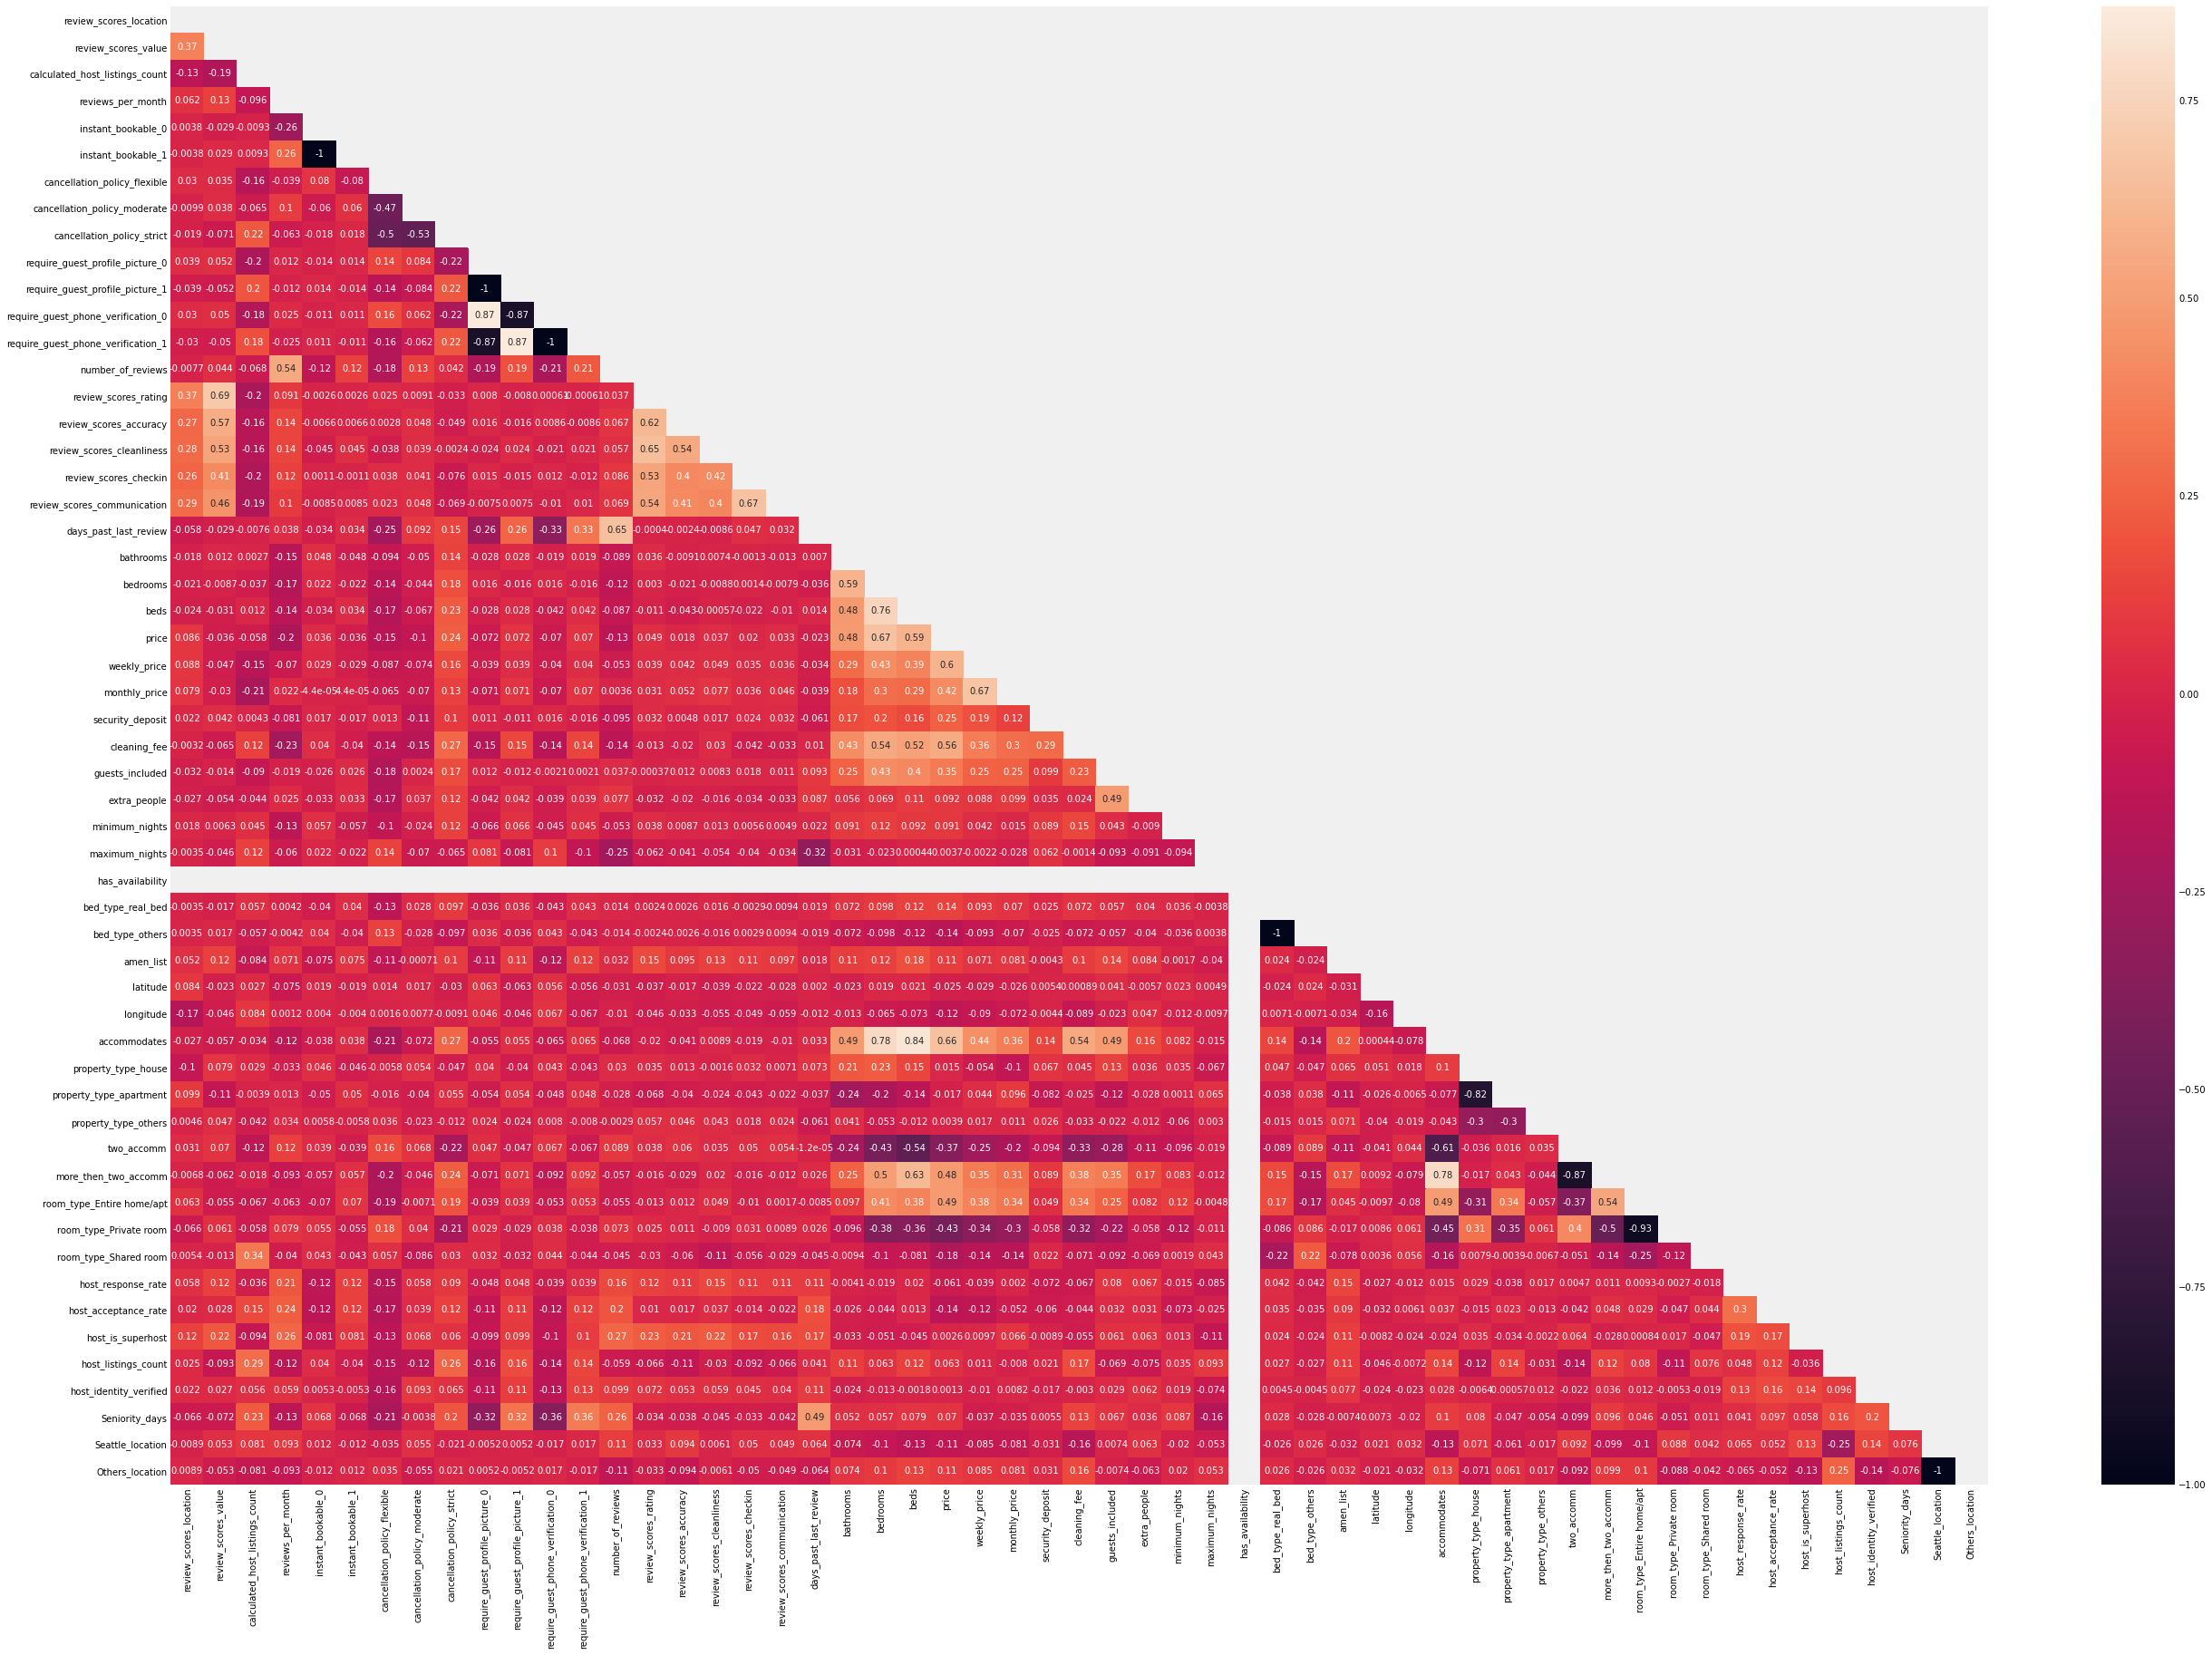

In [620]:
fig, ax = plt.subplots(figsize=(40,30)) 
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cbar = True, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values, mask=mask,ax=ax)

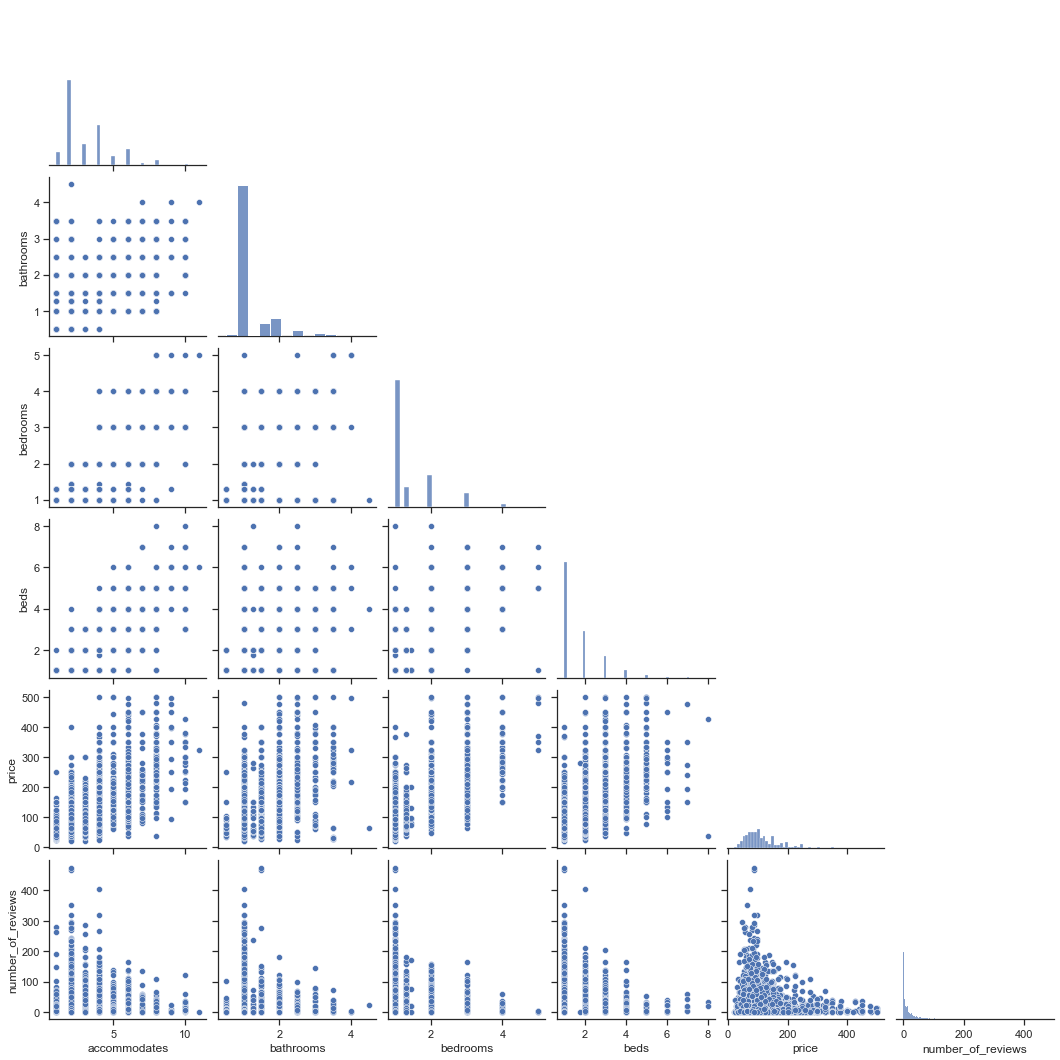

In [621]:
col = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews']
data = listings_short[col]
sns.set(style="ticks", color_codes=True)
sns.pairplot(data, corner = True)
plt.show()

<AxesSubplot:>

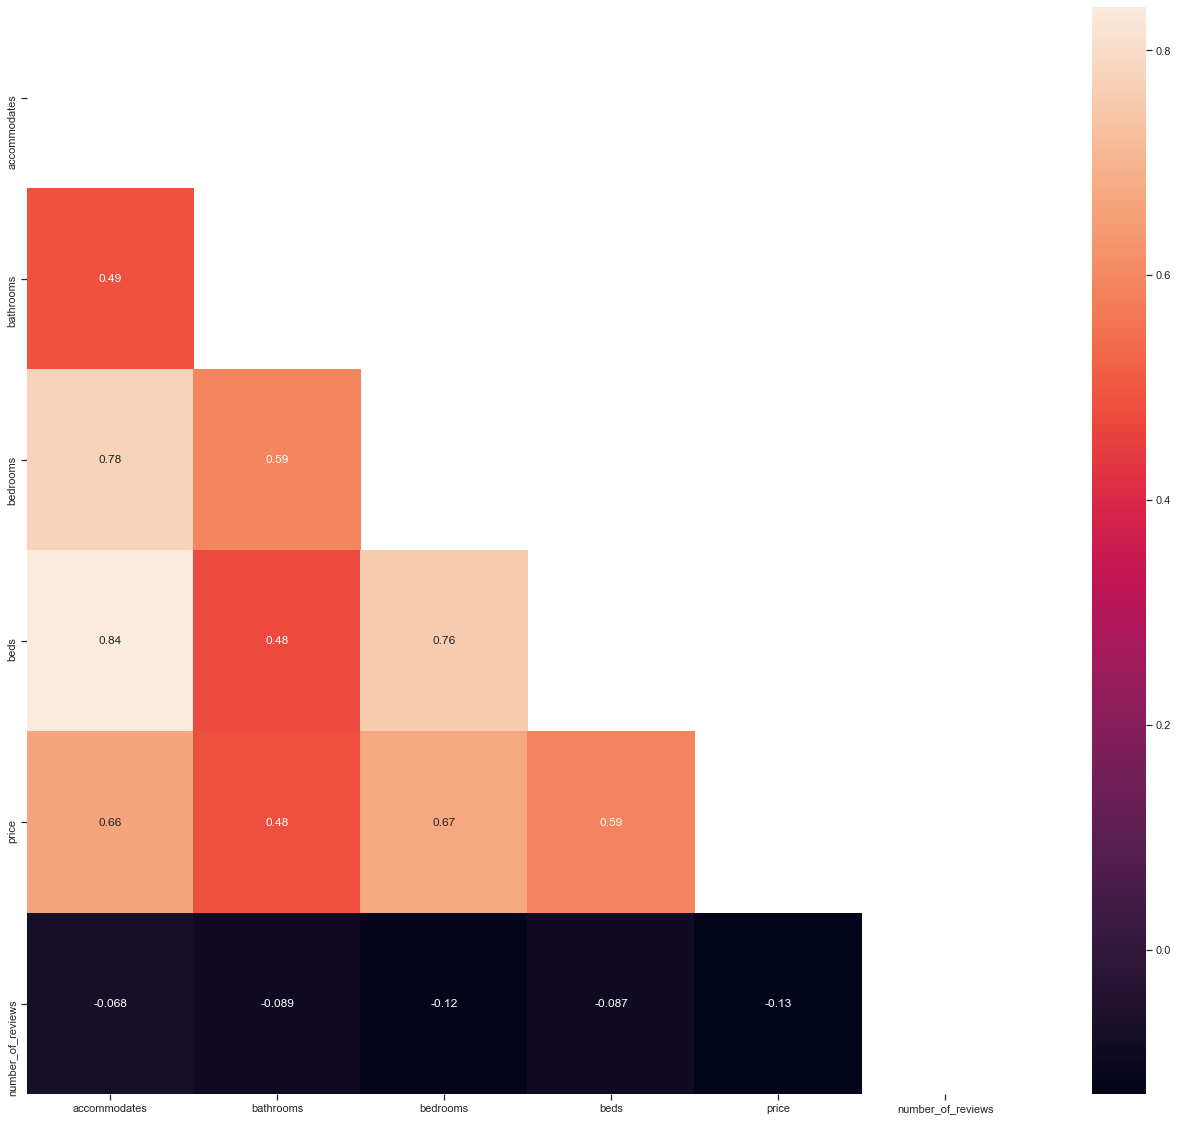

In [622]:
corr_2 = data.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
mask = np.triu(np.ones_like(corr_2))
sns.heatmap(corr_2, cbar = True, annot=True, xticklabels=corr_2.columns.values, 
            yticklabels=corr_2.columns.values, mask=mask,ax=ax)

<AxesSubplot:ylabel='Frequency'>

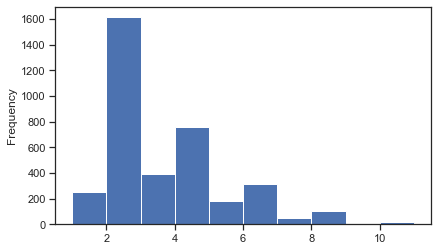

In [623]:
data.accommodates.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

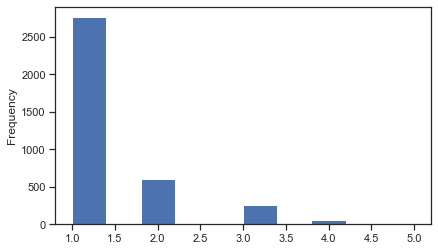

In [624]:
data.bedrooms.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

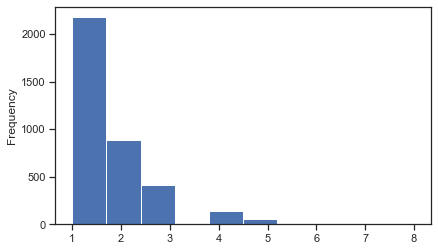

In [625]:
data.beds.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

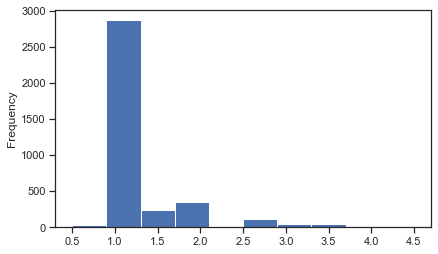

In [626]:
data.bathrooms.plot(kind='hist')

* From the above it is seen that all four are correlated and also have the same distribution \
We will keep the one with hiest coor with price and drop the others. 
accommodates & bedrooms have the same corr with price 0.66, 0.67 respectively
we will choose bedrooms as the value to keep.

In [627]:
listings_short.columns
listings_short.drop(['accommodates','beds','bedrooms'],axis=1,inplace=True)

In [629]:
listings_short.columns

Index(['review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'instant_bookable_0', 'instant_bookable_1',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'require_guest_profile_picture_0',
       'require_guest_profile_picture_1', 'require_guest_phone_verification_0',
       'require_guest_phone_verification_1', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'days_past_last_review', 'bathrooms',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability', 'bed_type_real_bed',
       'bed_type_others', 'amen_list', 'latitude', 'longitude',
       'property_type_house', 'property_type_apartment',
       'property

In [630]:
corr = listings_short.corr()

<AxesSubplot:>

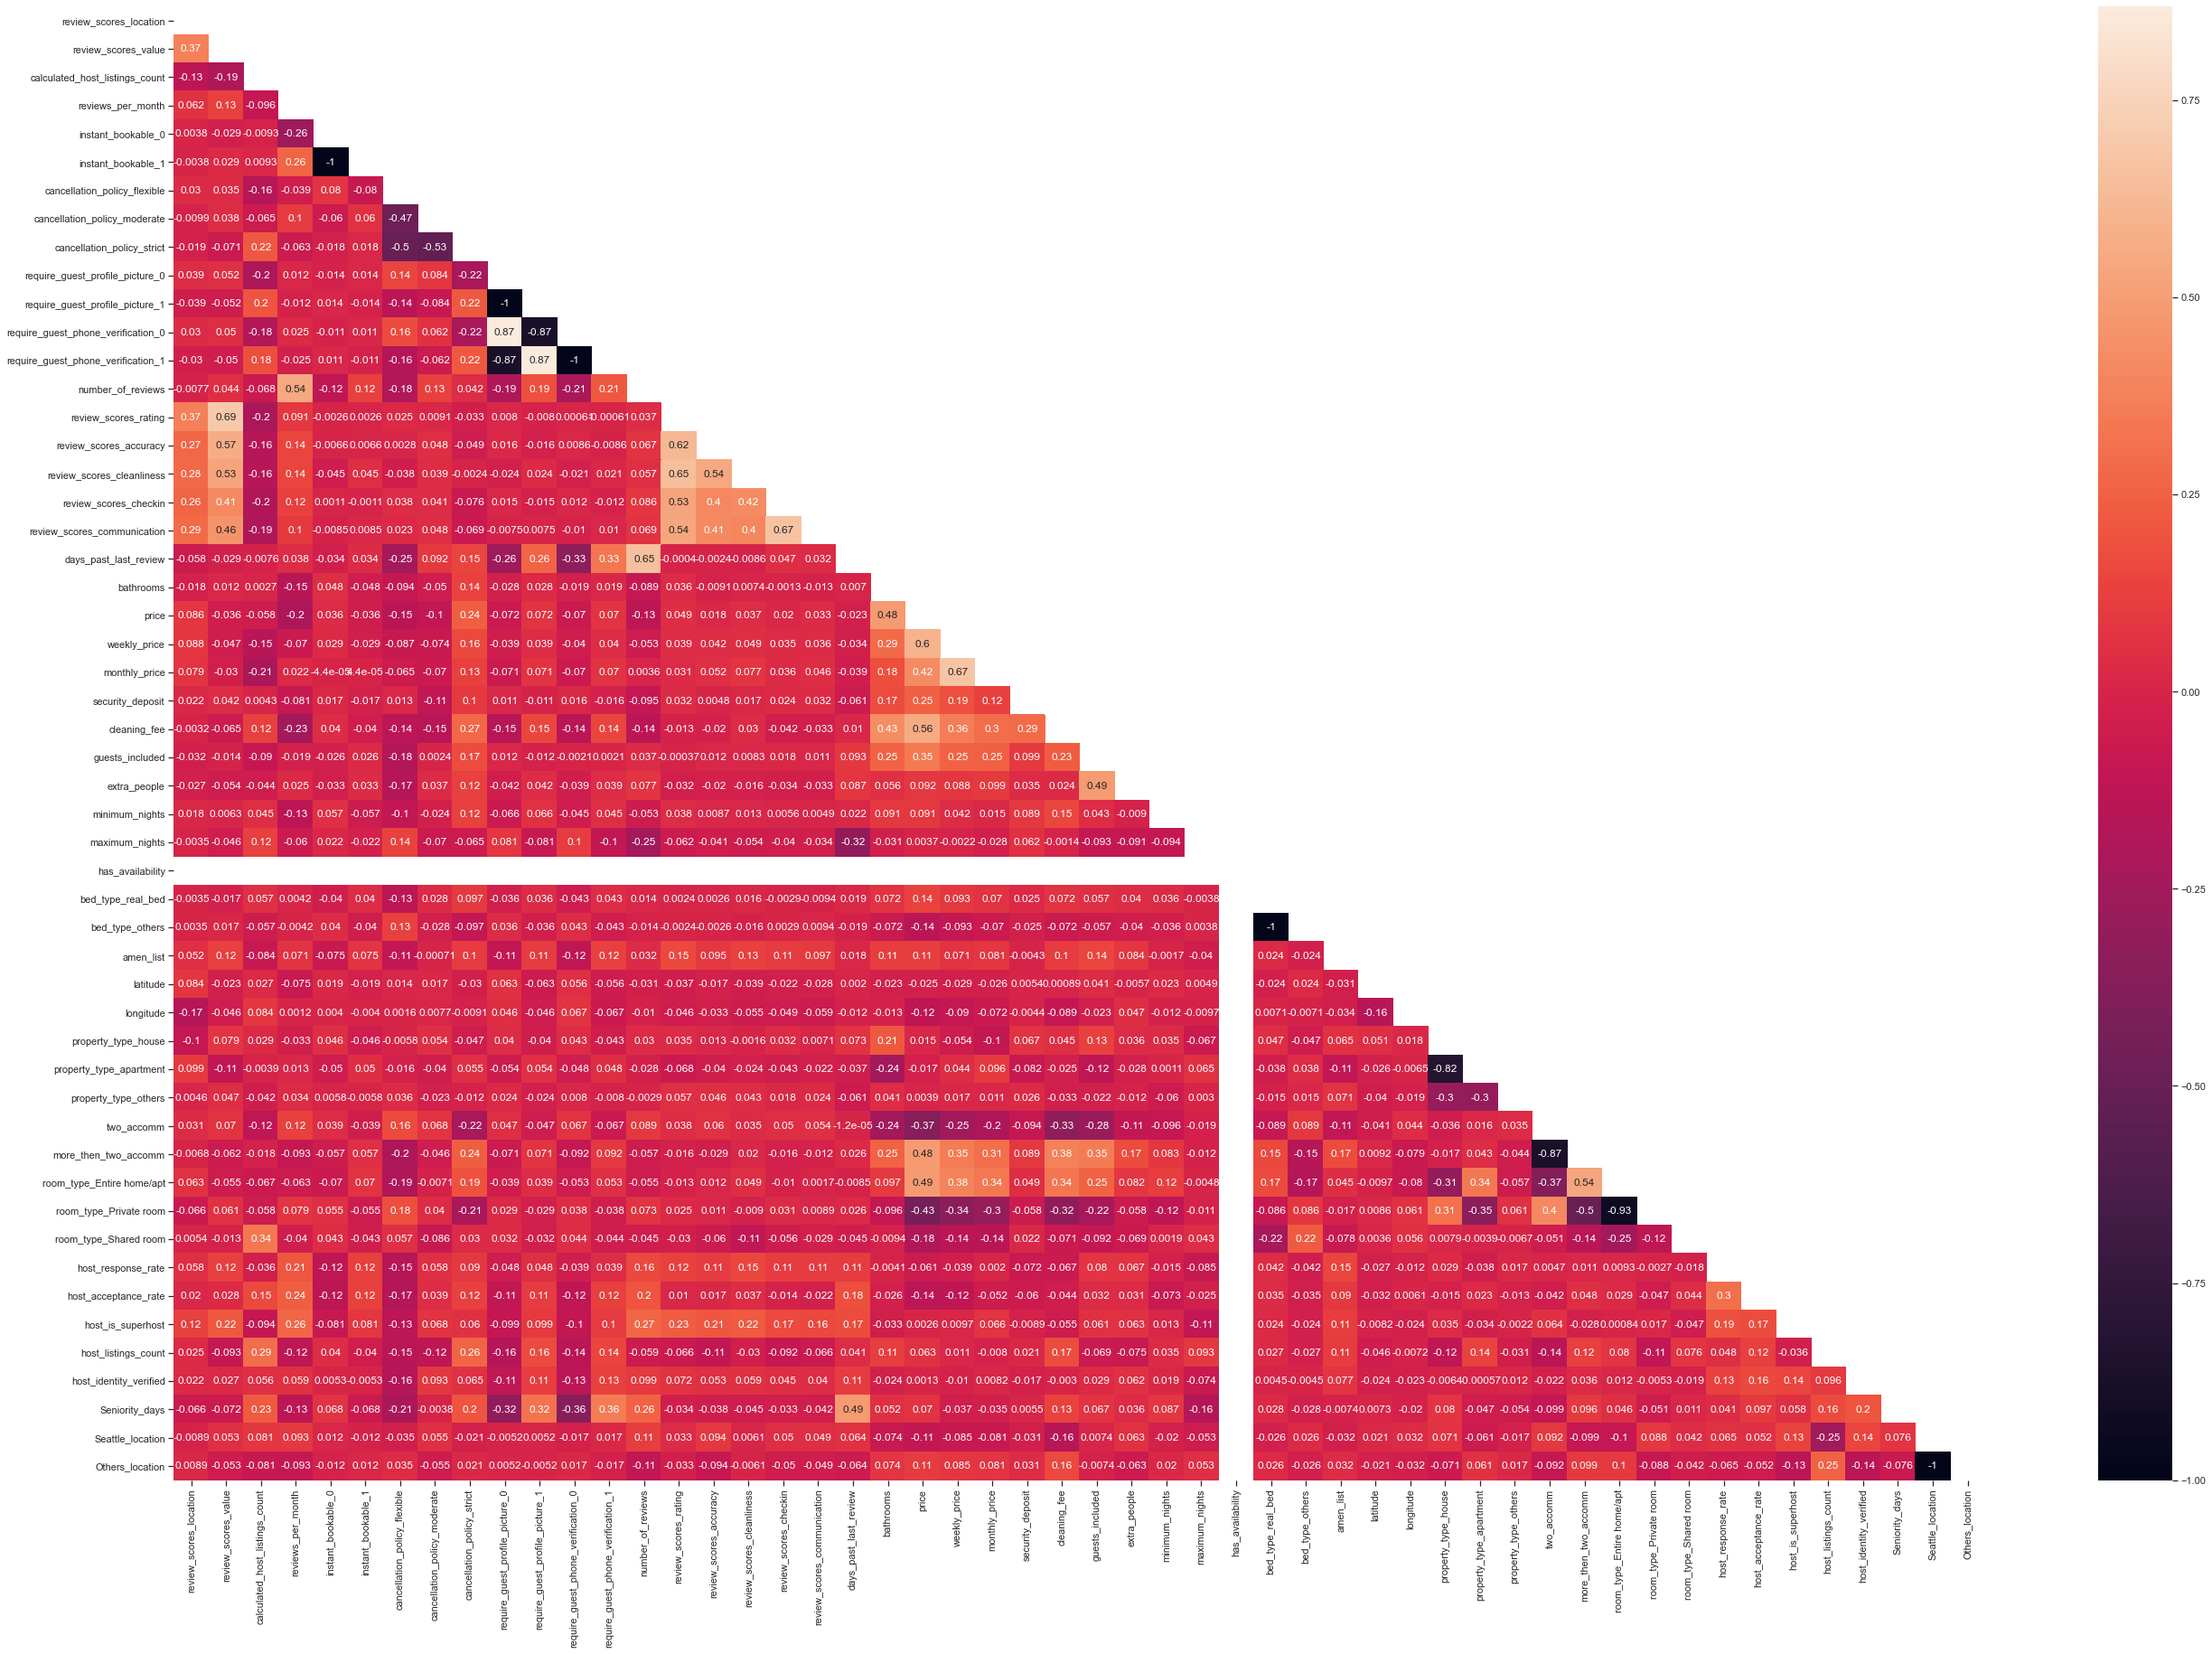

In [631]:
ig, ax = plt.subplots(figsize=(40,30)) 
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cbar = True, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values, mask=mask,ax=ax)

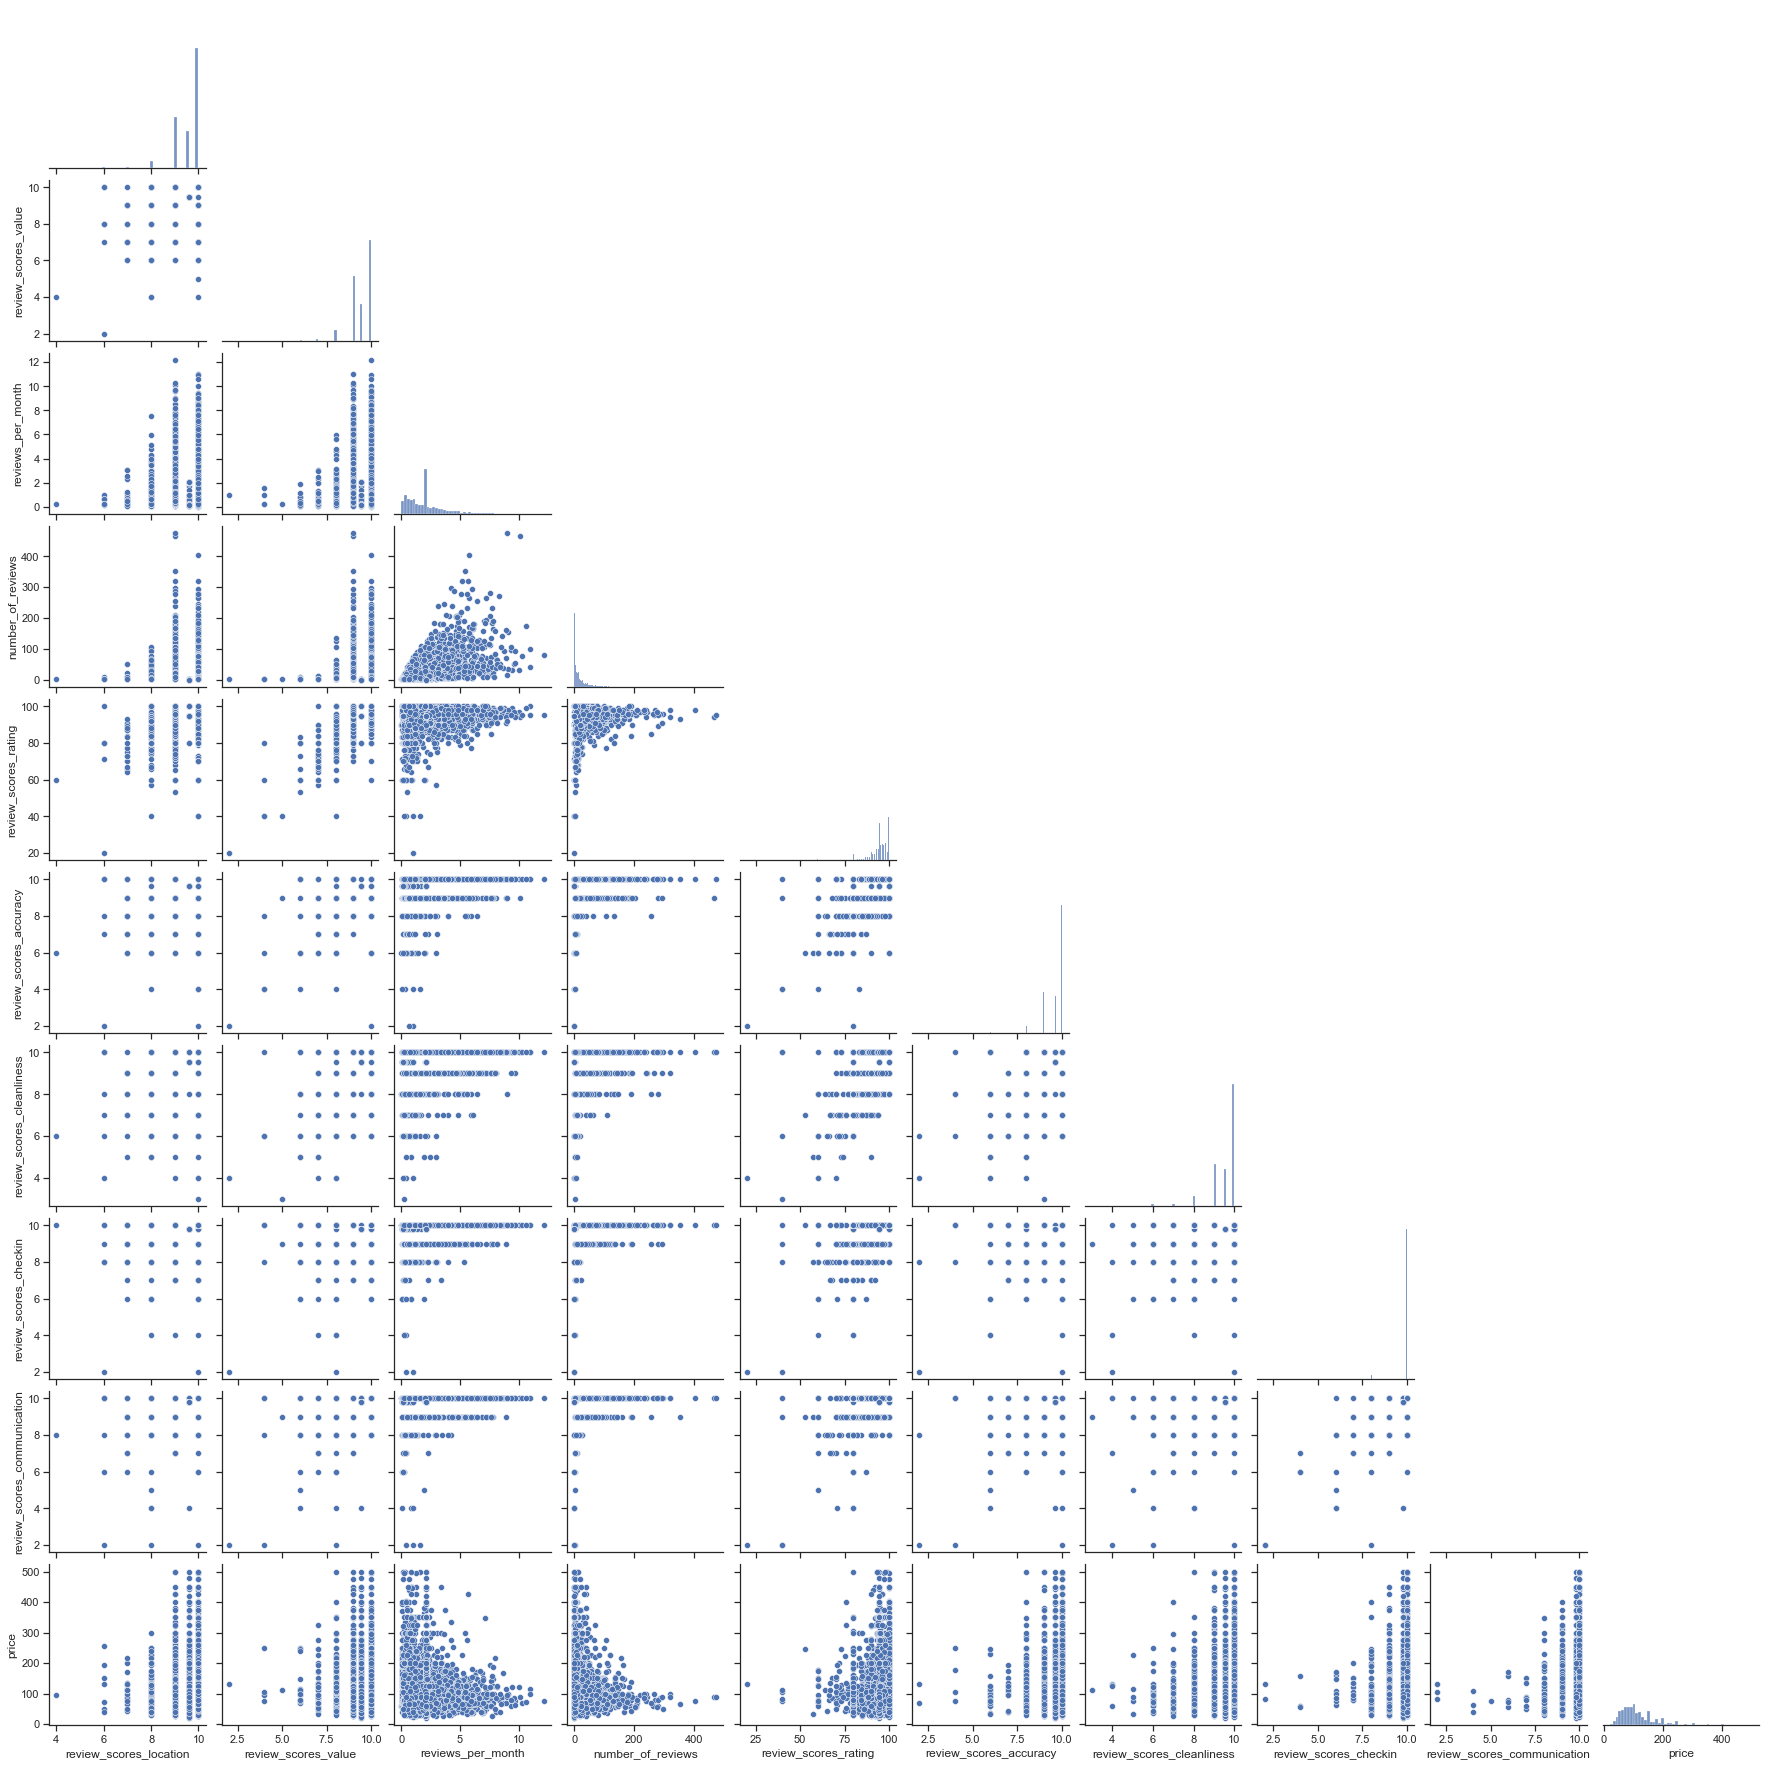

In [632]:
col = ['review_scores_location','review_scores_value','reviews_per_month','number_of_reviews',
       'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
       'review_scores_communication','price']
data = listings_short[col]
sns.set(style="ticks", color_codes=True)
sns.pairplot(data, corner = True)
plt.show()

* The only candidate looks like review_scores_rating that is corr with price

In [633]:
corr = data.corr()

<AxesSubplot:>

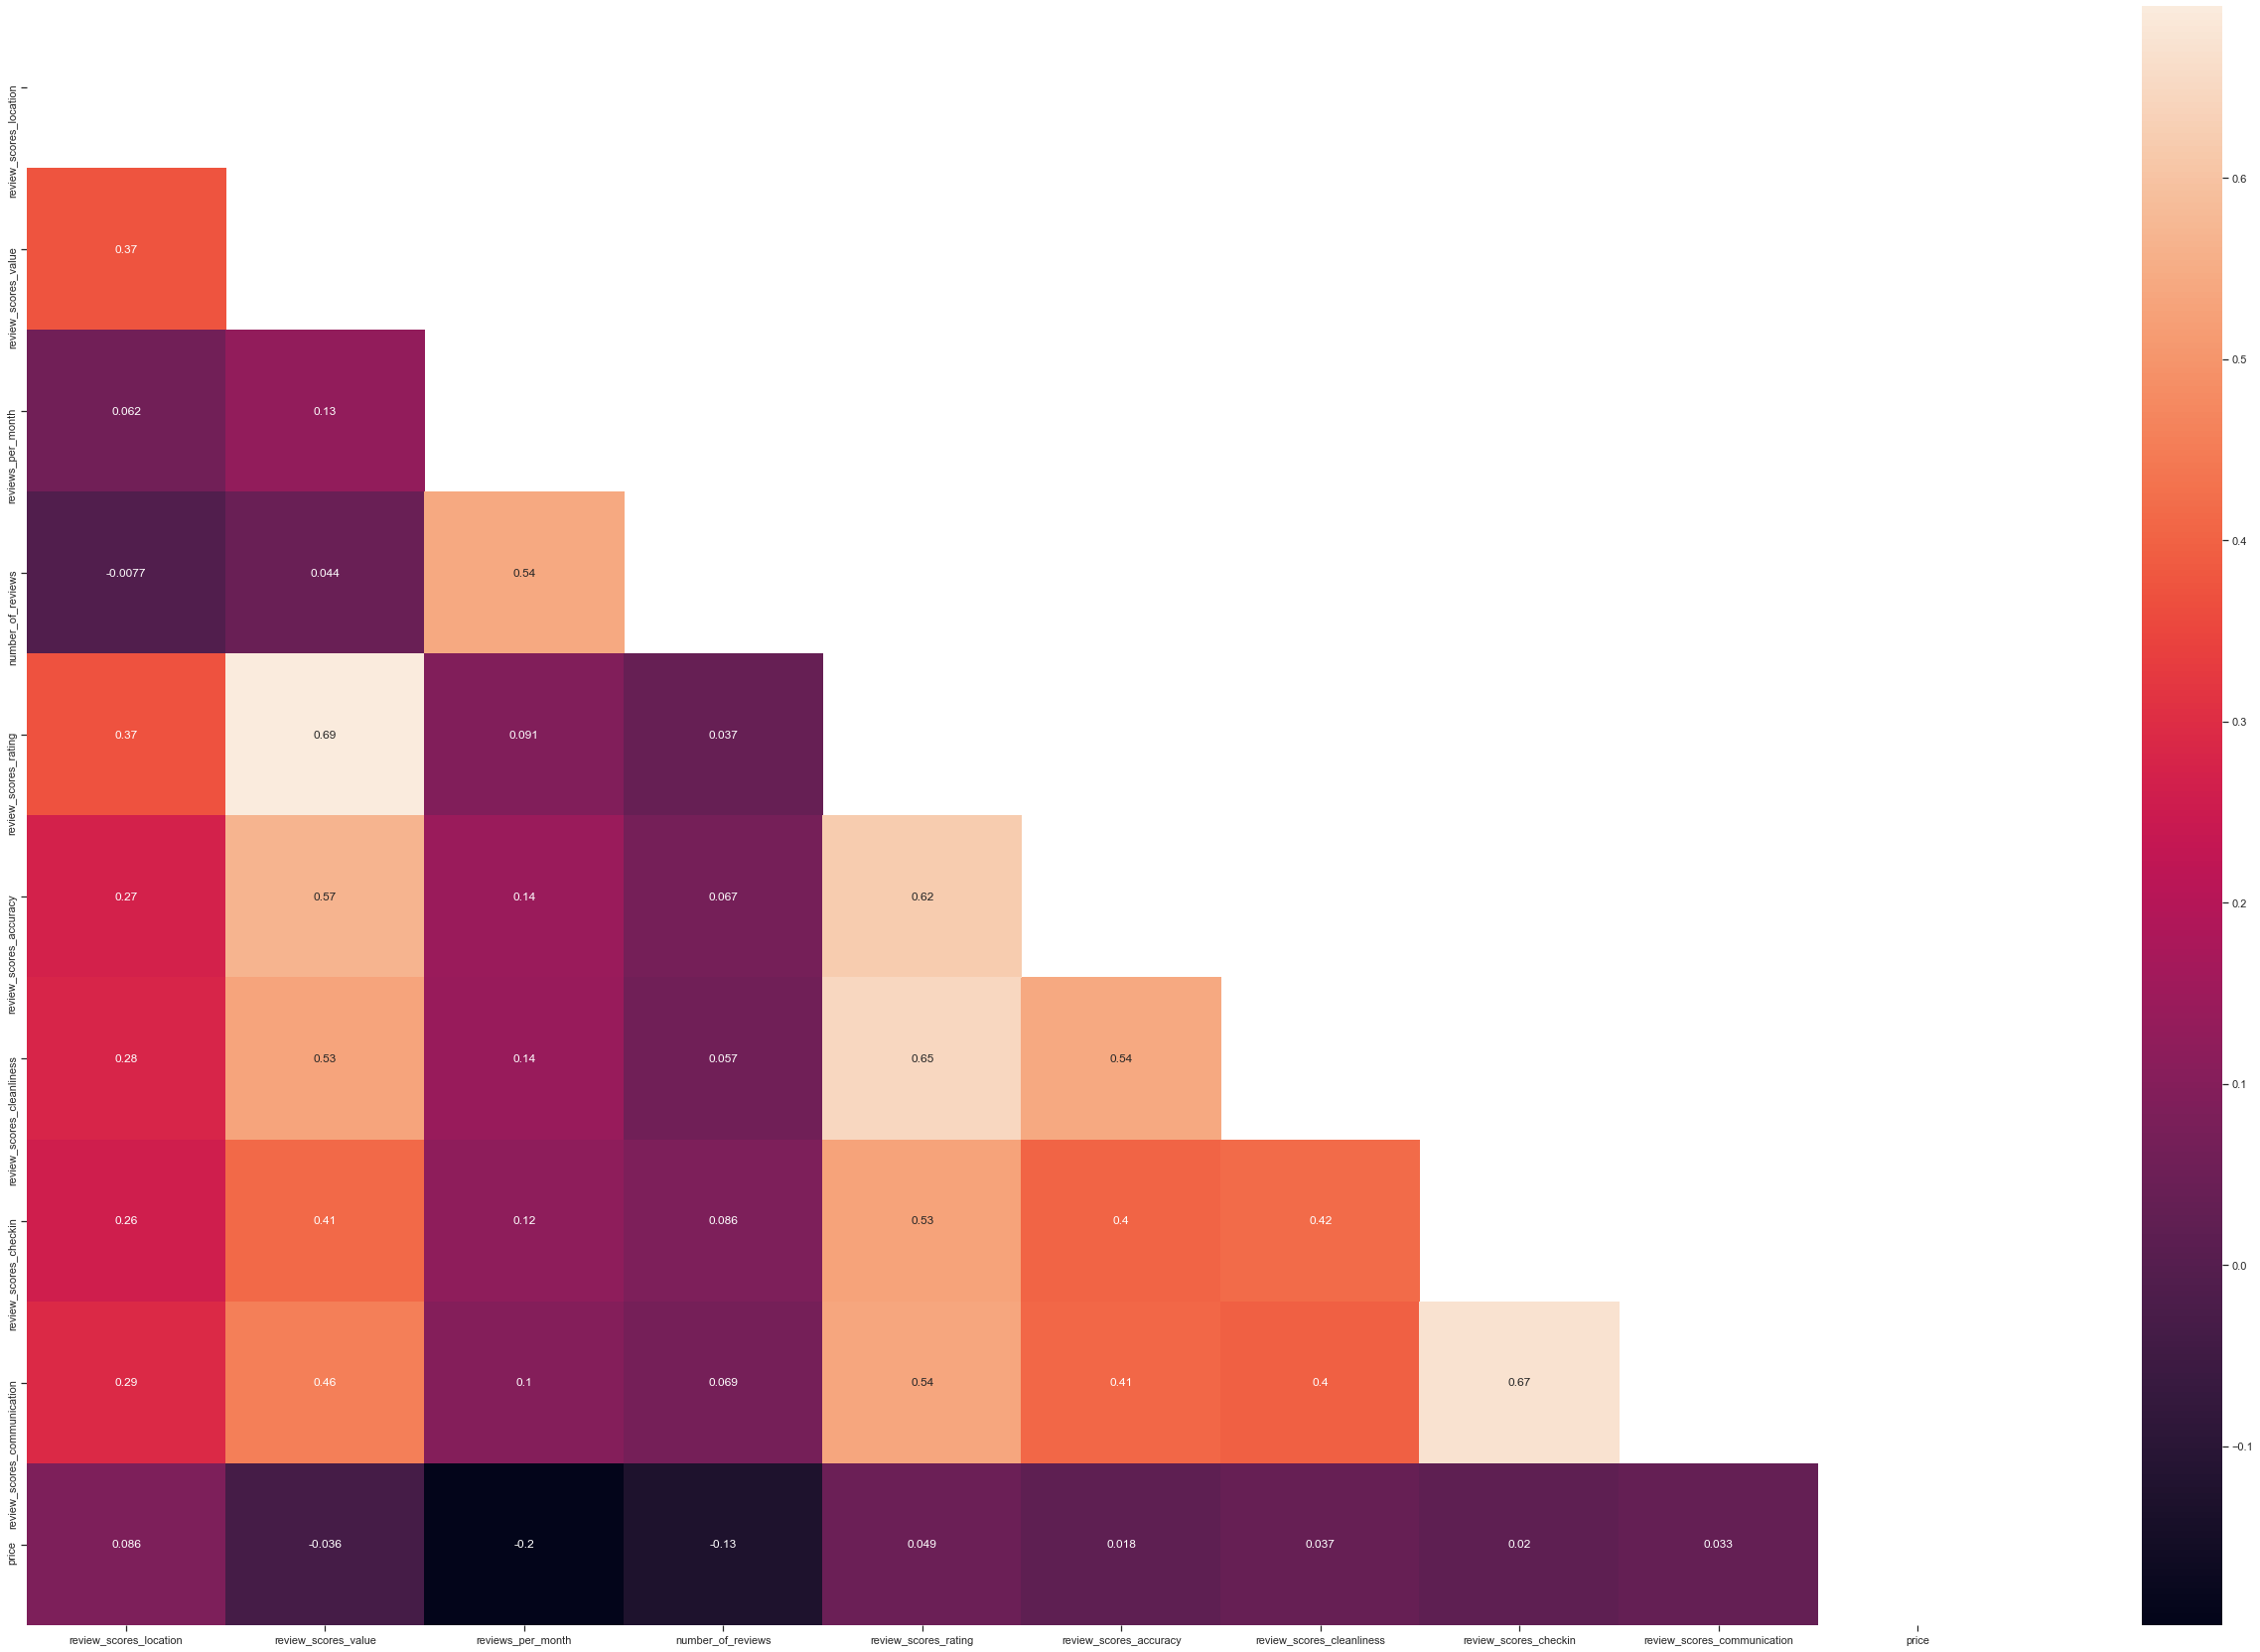

In [634]:
fig, ax = plt.subplots(figsize=(40,30)) 
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cbar = True, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values, mask=mask,ax=ax)
# Double click on the graph to enlarge the fonts

It's seems that price is not correlated with reviews \
All values are under 0.08
Also there is a high corellation between the veraibles: review_scores_rating/review_scores_communication/review_scores_checkin
review_scores_cleanliness/review_scores_accuracy
The hiest corr with price is for review_scores_rating = 0.049



In [635]:
listings_short.drop(['review_scores_communication','review_scores_checkin','review_scores_cleanliness',
                     'review_scores_accuracy'],axis=1,inplace=True)

In [636]:
corr = listings_short.corr()

<AxesSubplot:>

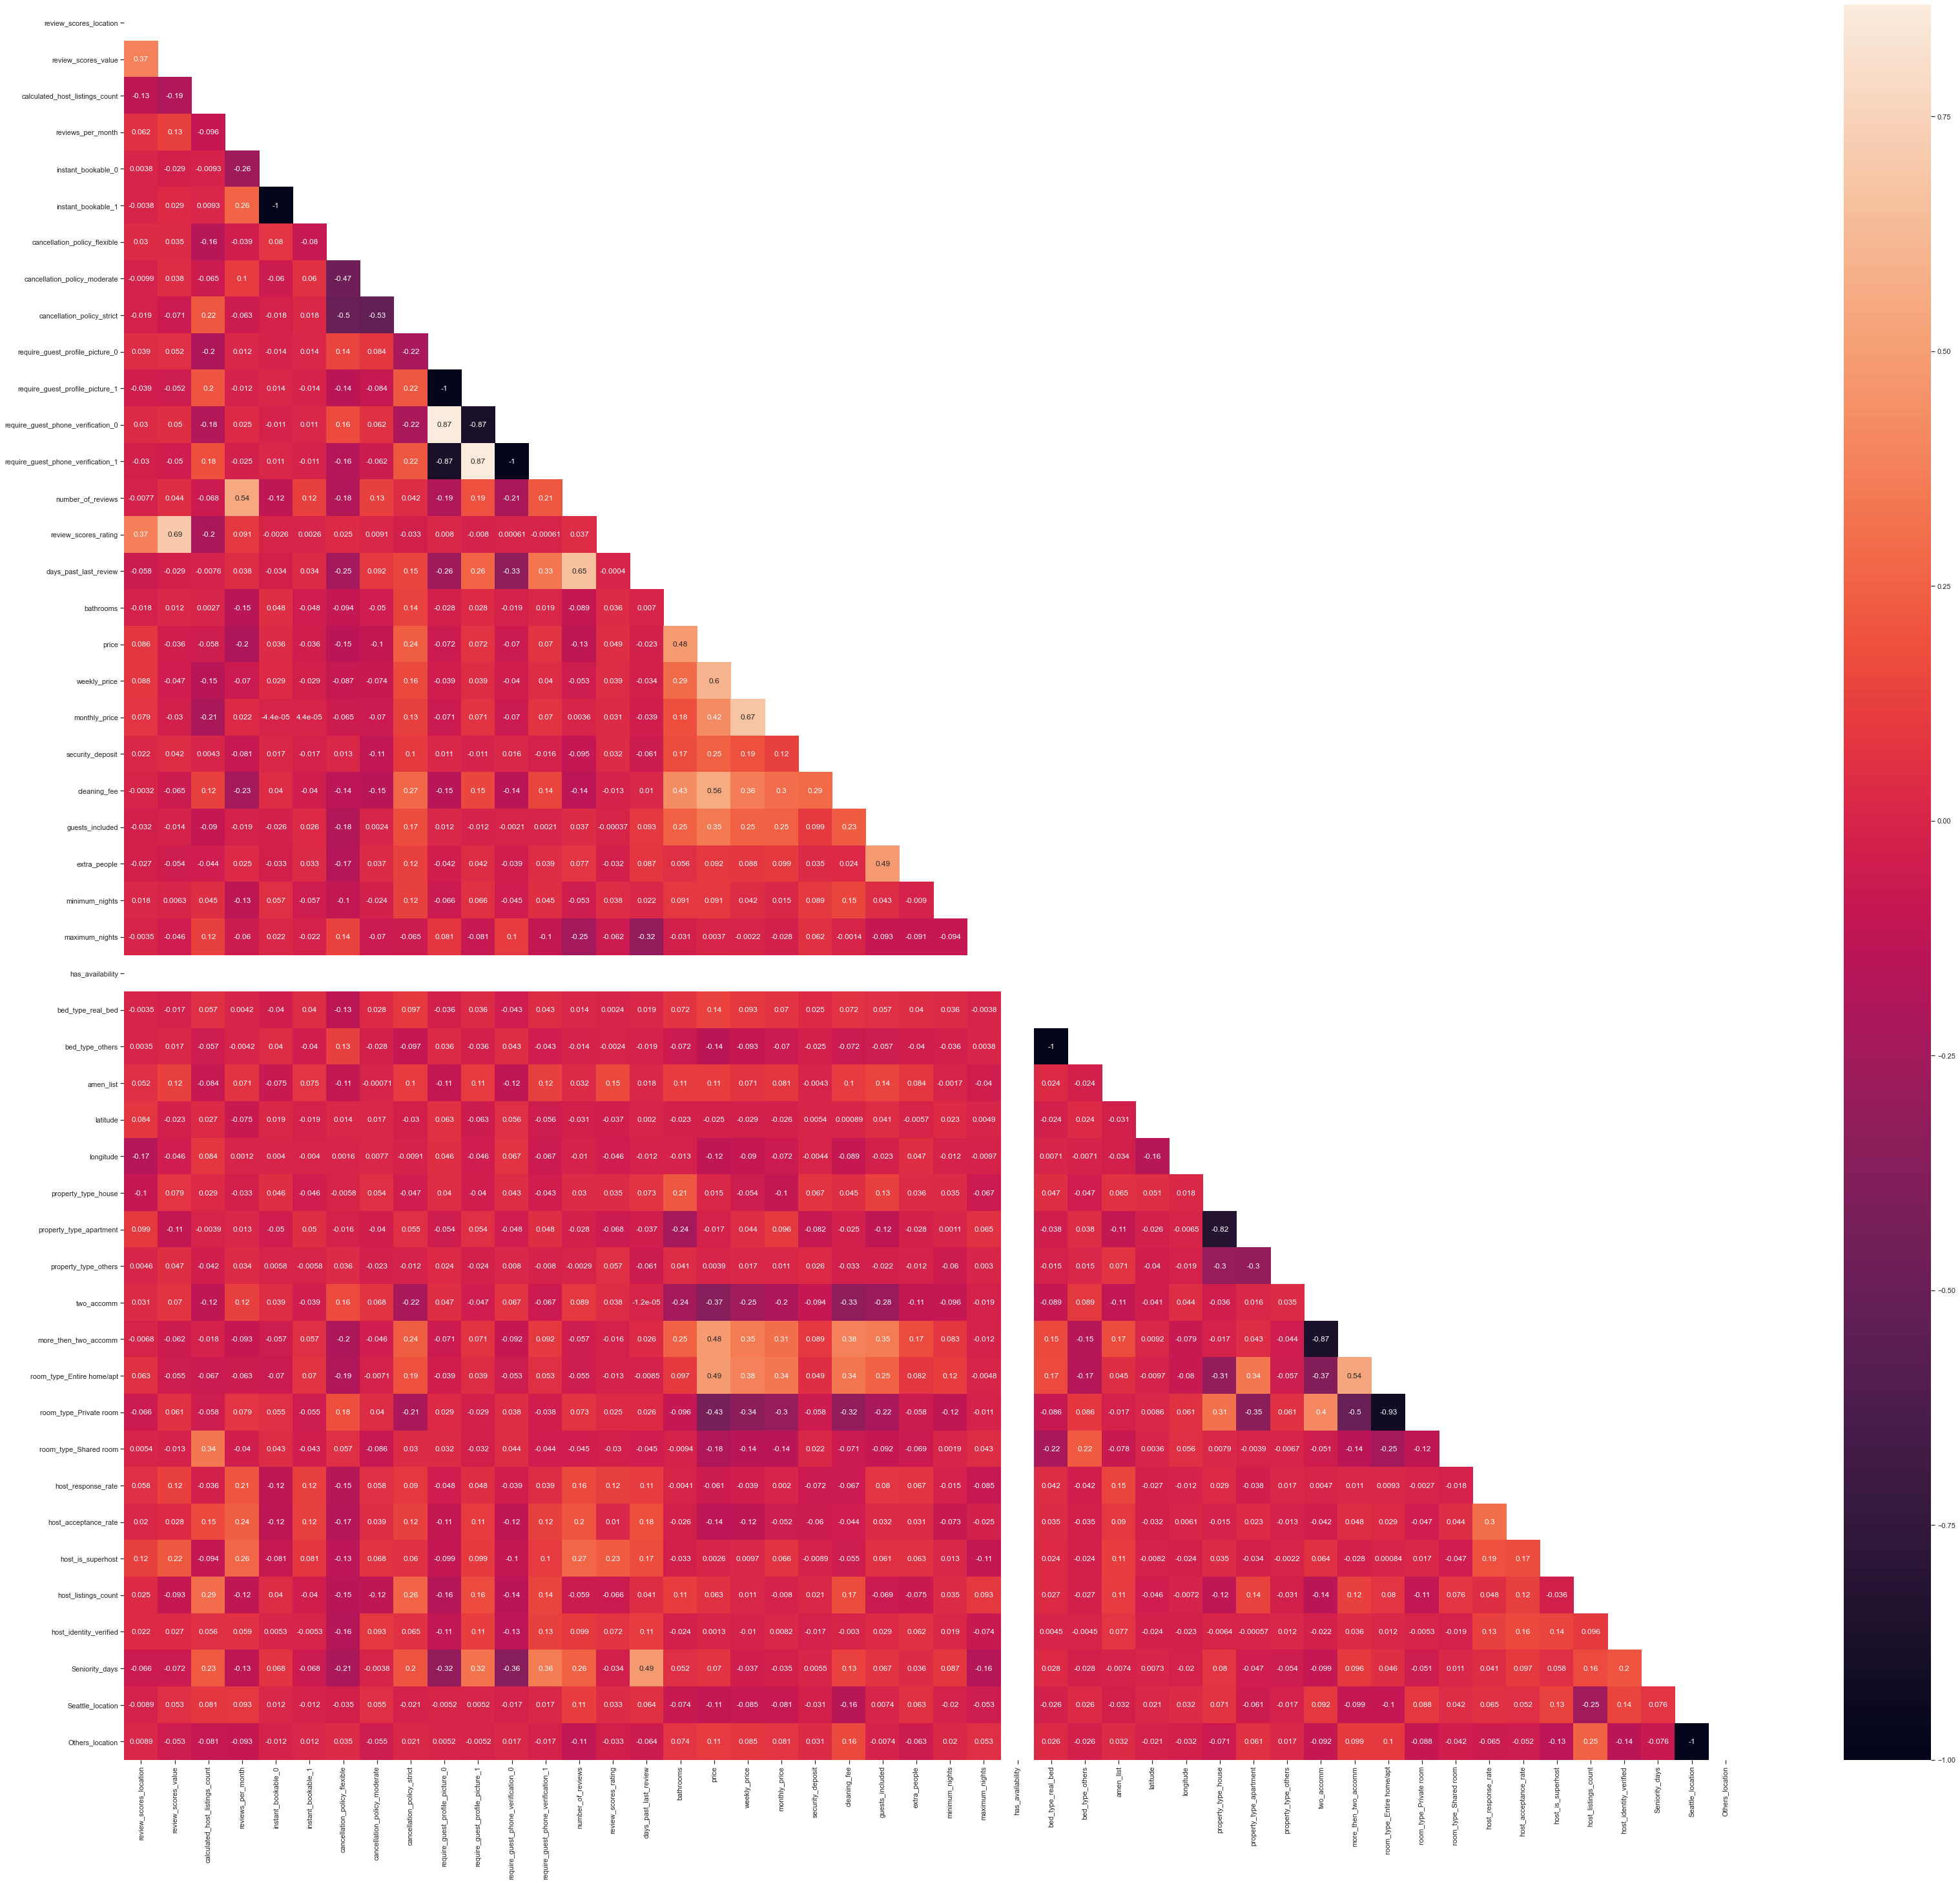

In [637]:
fig, ax = plt.subplots(figsize=(50,50)) 
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cbar = True, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values, mask=mask,ax=ax)

* The following pairs are hiely correlated: 0.87
require_guest_profile_picture_0, require_guest_phone_verification_0
require_guest_profile_picture_1, require_guest_phone_verification_1
both pairs have very low corr to price: |0.07|
we will drop the require_guest_profile_picture_0, require_guest_phone_verification_0 pair


In [638]:
listings_short.drop(['require_guest_profile_picture_0','require_guest_phone_verification_0'],axis=1,inplace=True)

* We will also drop review_score_value which is highly corr with review_score_rating \
review_score_value has very low corr with price: -0.036

In [639]:
listings_short.drop(['review_scores_value'],axis=1,inplace=True)

We can continue to select columns that are corr and drop some, \
for know we will leave the table as it is \
In the next step we will start to build the model

In [640]:
listings_short.columns

Index(['review_scores_location', 'calculated_host_listings_count',
       'reviews_per_month', 'instant_bookable_0', 'instant_bookable_1',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'require_guest_profile_picture_1',
       'require_guest_phone_verification_1', 'number_of_reviews',
       'review_scores_rating', 'days_past_last_review', 'bathrooms', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'has_availability', 'bed_type_real_bed', 'bed_type_others', 'amen_list',
       'latitude', 'longitude', 'property_type_house',
       'property_type_apartment', 'property_type_others', 'two_accomm',
       'more_then_two_accomm', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count'

# Question 3: Feature Eng.
1. What features can be engineered out of this data? Implement a few examples.
* Hint - make sure to also look at categorical features here


* New feature were already created on the EDA part
- Seniority_days
- One hot encoding
- Tailed distributions were breaked into 2 segments

Also a new feature was created with the beds & bedsrooms \
looking into their distribution they are both picking on the value 2  \
So we can join them togather into a bool parametr: 2/more then 2

# Question 4: Modelling.
1. Build a model to predict the target
* How many different modeling approaches do you know? what are the pros & cons of each one?
* Can you improve the results with a different modeling approach?
* Which metric would you optimize? Why?
* What is the best model score according to this metric?

In [673]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

In [830]:
X = listings_short.drop('price',axis=1)
y = listings_short['price']

In [831]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

* K fold Linear Regression 

In [676]:
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)

In [677]:
lr = LinearRegression()

In [678]:
scoring = 'neg_mean_absolute_error'
results = model_selection.cross_val_score(lr, X, y, cv=kfold, scoring=scoring)
print("MAE: %.3f" % (results.mean()))

MAE: -29.936


In [679]:
scoring = 'r2'
results = model_selection.cross_val_score(lr, X, y, cv=kfold, scoring=scoring)
print("R^2: %.3f" % (results.mean()))

R^2: 0.620


In [680]:
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(lr, X, y, cv=kfold, scoring=scoring)
print("MSE: %.3f" % (results.mean()))

MSE: -1914.870


* Linear Regression

In [681]:
lr.fit(X_train,y_train)

LinearRegression()

In [682]:
y_pred = lr.predict(X_test)

C:\Users\berge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted')

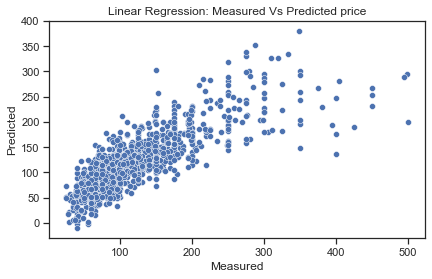

In [733]:
sns.scatterplot(y_test,y_pred)
plt.title('Linear Regression: Measured Vs Predicted price')
plt.xlabel('Measured')
plt.ylabel('Predicted')

In [709]:
print("MAE: %.2f" %metrics.mean_absolute_error(y_test,y_pred))
print("MSE: %.2f" %metrics.mean_squared_error(y_test,y_pred))
print("RMSE: %.2f" %np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

MAE: 29.27
MSE: 1796.17
RMSE: 42.38


* Random Forest

In [832]:
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 38.478
R^2 test: 0.709


In [660]:
# Finding most importent features
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

est_int     coefs
17               cleaning_fee  0.226668
14               weekly_price  0.151935
33  room_type_Entire home/apt  0.134849
13                  bathrooms  0.134283
27                  longitude  0.034521
26                   latitude  0.031921
25                  amen_list  0.031421
41             Seniority_days  0.030284
2           reviews_per_month  0.027110
32       more_then_two_accomm  0.025872
12      days_past_last_review  0.014460
10          number_of_reviews  0.012734
11       review_scores_rating  0.012229
16           security_deposit  0.012103
15              monthly_price  0.010496
20             minimum_nights  0.010416
39        host_listings_count  0.009335
21             maximum_nights  0.008987
19               extra_people  0.008743
36         host_response_rate  0.008382

* Pipe line example

In [661]:
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error 


In [662]:
y = listings_short.price
X = listings_short.drop('price', axis=1)

In [663]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [664]:
pipelines = {
    'lasso' : make_pipeline(StandardScaler(),
              Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(),
              Ridge(random_state=123)),
    'enet' :  make_pipeline(StandardScaler(),
              ElasticNet(random_state=123)),
    'rf' :    make_pipeline(
              RandomForestRegressor(random_state=123)),
    'gb' :    make_pipeline(
              GradientBoostingRegressor(random_state=123))
}

In [665]:
hyperparameters = {
    'lasso' : {'lasso__alpha'      : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
    'ridge' : {'ridge__alpha'      : [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5, 10]},
    'enet'  : {'elasticnet__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10], 
               'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]},
    'rf'    : {'randomforestregressor__n_estimators'  : [100, 200],
                'randomforestregressor__max_features' : ['auto', 'sqrt', 0.33],
                'randomforestregressor__min_samples_leaf' : [1, 3, 5, 10]},
    'gb'    : {'gradientboostingregressor__n_estimators'  : [100, 200],
               'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
               'gradientboostingregressor__max_depth'     : [1, 3, 5]}}


In [666]:
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name],
                         cv=10, 
                         n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model


In [667]:
for name, model in fitted_models.items():
    print(name, model.best_score_ )
    

lasso 0.620354695500103
ridge 0.619987826613251
enet 0.6204332272936404
rf 0.6968852315838092
gb 0.6988607617141829


In [668]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print(' — — — — ')
    print('R²:', r2_score(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))


lasso
 — — — — 
R²: 0.6210156335834306
MAE: 29.128409819407327
ridge
 — — — — 
R²: 0.6211045560559598
MAE: 29.13595648099125
enet
 — — — — 
R²: 0.6213302038942268
MAE: 29.10643001659855
rf
 — — — — 
R²: 0.6801461647864885
MAE: 24.218816147998552
gb
 — — — — 
R²: 0.6660227810260166
MAE: 24.24387744577559


# Question 5: External Data
Imagine that you could have access to external data sources, which you could join with your data in order to better predict the price.
1. Which dataset would you add? Could you give examples of features that might help?
2. Could you try adding one external data source (from the internet) to your data? Did it help the accuracy of your model?
3. If you find this task to be unclear - think of the following example - If one wanted to predict the number of passengers in international flights in 2020 - an external dataset with the number of covid-19 cases per day would probably be very helpful...


* Holiday list 
* Criminal Distribution map - https://www.seattle.gov/police/information-and-data/crime-dashboard
* Development ares planning (Roads/schools/shopping mall/Parks)
* Recession periods
* epidemic crisis


In [776]:
df_crime = pd.read_csv('Map_Full_Data_data.csv')
df_crime.head()

Boundary Selection Incomplete Month Beat                 MCPP  \
0  DOWNTOWN COMMERCIAL   Complete Month   K2  DOWNTOWN COMMERCIAL   
1  DOWNTOWN COMMERCIAL   Complete Month   K2  DOWNTOWN COMMERCIAL   
2  DOWNTOWN COMMERCIAL   Complete Month   K2  DOWNTOWN COMMERCIAL   
3  DOWNTOWN COMMERCIAL   Complete Month   K2  DOWNTOWN COMMERCIAL   
4  DOWNTOWN COMMERCIAL   Complete Month   K2  DOWNTOWN COMMERCIAL   

        Offense Offense Start DateTime Precinct SeaStat Category   \
0  Intimidation   2/23/2016 8:53:00 PM     West   All Other Crime   
1  Intimidation   1/23/2016 7:14:00 AM     West   All Other Crime   
2  Intimidation   1/27/2016 3:30:00 AM     West   All Other Crime   
3  Intimidation    2/2/2016 3:31:00 AM     West   All Other Crime   
4  Intimidation    3/8/2016 9:43:00 PM     West   All Other Crime   

    SeaStat Offense     100 Block Address  ...   Latitude   Longitude  \
0  Assault Offenses    2ND AVE / JAMES ST  ...  47.602306 -122.332519   
1  Assault Offenses  5XX BLOCK OF 3RD AVE  ...  47.602412 -122.331082   
2  Assault Offenses  5XX BLOCK OF 3RD AVE  ...  47.602412 -122.331082   
3  Assault Offenses  5XX BLOCK OF 3RD AVE  ...  47.602412 -122.331082   
4  Assault Offenses  5XX BLOCK OF 3RD AVE  ...  47.602412 -122.331082   

  Map Boundaries Number of Records    St Area Sh st area sh (BEAT MAP.shp)  \
0        Polygon                 1  3.903963e+08              1.970489e+07   
1        Polygon                 1  3.903963e+08              1.970489e+07   
2        Polygon                 1  3.903963e+08              1.970489e+07   
3        Polygon                 1  3.903963e+08              1.970489e+07   
4        Polygon                 1  3.903963e+08              1.970489e+07   

   st area sh (MCPP MAP.shp)      St Length st length  (BEAT MAP.shp)  \
0               1.732340e+07  115256.614048              24228.649801   
1               1.732340e+07  115256.614048              24228.649801   
2               1.732340e+07  115256.614048              24228.649801   
3               1.732340e+07  115256.614048              24228.649801   
4               1.732340e+07  115256.614048              24228.649801   

  st length  (MCPP MAP.shp)  
0              20647.668763  
1              20647.668763  
2              20647.668763  
3              20647.668763  
4              20647.668763  

[5 rows x 38 columns]

In [802]:
df_crime_clean = df_crime[['Latitude','Longitude','Number of Records']].copy()
df_crime_clean.shape

(6294, 3)

In [818]:
df_crime_clean = df_crime_clean.groupby(['Latitude', 'Longitude'])[['Number of Records']].sum().reset_index()

In [819]:
df_crime_clean.head()

Latitude   Longitude  Number of Records
0   0.000000    0.000000                108
1  47.601704 -122.325479                  3
2  47.601710 -122.326351                  5
3  47.601712 -122.327686                  5
4  47.601716 -122.330265                 43

In [820]:
df_list = [listings_short,df_crime_clean]
listings_crime = pd.concat(df_list, axis=1)
listings_crime.head()

review_scores_location  calculated_host_listings_count  reviews_per_month  \
0                9.000000                             2.0           4.070000   
1               10.000000                             6.0           1.480000   
2                     NaN                             NaN                NaN   
3                9.608916                             1.0           2.078919   
4                9.000000                             1.0           0.890000   

   instant_bookable_0  instant_bookable_1  cancellation_policy_flexible  \
0                 1.0                 0.0                           0.0   
1                 1.0                 0.0                           0.0   
2                 NaN                 NaN                           NaN   
3                 1.0                 0.0                           1.0   
4                 1.0                 0.0                           0.0   

   cancellation_policy_moderate  cancellation_policy_strict  \
0                           1.0                         0.0   
1                           0.0                         1.0   
2                           NaN                         NaN   
3                           0.0                         0.0   
4                           0.0                         1.0   

   require_guest_profile_picture_1  require_guest_phone_verification_1  ...  \
0                              0.0                                 0.0  ...   
1                              1.0                                 1.0  ...   
2                              NaN                                 NaN  ...   
3                              0.0                                 0.0  ...   
4                              0.0                                 0.0  ...   

   host_acceptance_rate  host_is_superhost  host_listings_count  \
0            100.000000                0.0                  3.0   
1            100.000000                1.0                  6.0   
2                   NaN                NaN                  NaN   
3             79.727606                0.0                  1.0   
4             79.727606                0.0                  2.0   

   host_identity_verified  Seniority_days  Seattle_location  Others_location  \
0                     1.0          1607.0               1.0              0.0   
1                     1.0          1047.0               1.0              0.0   
2                     NaN             NaN               NaN              NaN   
3                     1.0           789.0               1.0              0.0   
4                     1.0          1497.0               1.0              0.0   

    Latitude   Longitude  Number of Records  
0   0.000000    0.000000              108.0  
1  47.601704 -122.325479                3.0  
2  47.601710 -122.326351                5.0  
3  47.601712 -122.327686                5.0  
4  47.601716 -122.330265               43.0  

[5 rows x 48 columns]

In [821]:
listings_crime.dropna(axis=0,inplace=True)

In [824]:
listings_crime.head()

review_scores_location  calculated_host_listings_count  reviews_per_month  \
0                9.000000                             2.0           4.070000   
1               10.000000                             6.0           1.480000   
3                9.608916                             1.0           2.078919   
4                9.000000                             1.0           0.890000   
5               10.000000                             1.0           2.450000   

   instant_bookable_0  instant_bookable_1  cancellation_policy_flexible  \
0                 1.0                 0.0                           0.0   
1                 1.0                 0.0                           0.0   
3                 1.0                 0.0                           1.0   
4                 1.0                 0.0                           0.0   
5                 1.0                 0.0                           0.0   

   cancellation_policy_moderate  cancellation_policy_strict  \
0                           1.0                         0.0   
1                           0.0                         1.0   
3                           0.0                         0.0   
4                           0.0                         1.0   
5                           0.0                         1.0   

   require_guest_profile_picture_1  require_guest_phone_verification_1  ...  \
0                              0.0                                 0.0  ...   
1                              1.0                                 1.0  ...   
3                              0.0                                 0.0  ...   
4                              0.0                                 0.0  ...   
5                              0.0                                 0.0  ...   

   host_acceptance_rate  host_is_superhost  host_listings_count  \
0            100.000000                0.0                  3.0   
1            100.000000                1.0                  6.0   
3             79.727606                0.0                  1.0   
4             79.727606                0.0                  2.0   
5             79.727606                0.0                  1.0   

   host_identity_verified  Seniority_days  Seattle_location  Others_location  \
0                     1.0          1607.0               1.0              0.0   
1                     1.0          1047.0               1.0              0.0   
3                     1.0           789.0               1.0              0.0   
4                     1.0          1497.0               1.0              0.0   
5                     1.0          1836.0               1.0              0.0   

    Latitude   Longitude  Number of Records  
0   0.000000    0.000000              108.0  
1  47.601704 -122.325479                3.0  
3  47.601712 -122.327686                5.0  
4  47.601716 -122.330265               43.0  
5  47.601717 -122.331561                1.0  

[5 rows x 48 columns]

In [826]:
X = listings_crime.drop('price',axis=1)
y = listings_crime['price']

In [827]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [828]:
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 35.044
R^2 test: 0.757


It's seems that we imporve the score from the last attempt: \
RMSE test: 38.478 \
R^2 test: 0.709

# Question 6: business thinking.


1. After looking and exploring this data. Apart from predicting the price, could you think of some business problems for Airbnb? Do you have any ideas on how to solve them (no code is needed).

Some other problems that can be arrise to Airbnb:
- Criminal activity:
Areas can become not safe for rental due to safety of the renters. \
When allocating new apartments, the area can be analyzed accourding to the "criminal rate map" that show for each region \
the occourences of violenc roberry etc. \
If there is an hazared then maybe it is better to declined the property in order to keep the reputation of the business 

- Customer default on the property payments \
When listing a new property the company need to assure that it is stable  \
Meanning, the property will not be at risk, as been taken by the bank due to un paid loan etc. \
One way to overcome this is by checking the finance of the property owners, or credict status. \
If the data exist then airbnb can check if a reasnable insitation will give the owner a loan \
A refuse can tell somthing about the stability of the owners.

- Problematics cuntomers
When dealing with people it is highly possible that some will get angry/frustrated from the service \
This can lead to demege to property. By collecting the customers score, the company can supply to owners \
a way to reduce risk. This way certain customer will not be able to book if thay will have bad score.